## Проект: Линейные модели в машинном обучении

### Описание проекта
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

### Цель проекта:

Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.
### Инструкции по выполнению  проекта:
Разработать модель, которая предскажет вероятность снижения покупательской активности.

Выделить сегмент покупателей, проанализировать его и предложить, как увеличить его покупательскую активность. Использовать данные моделирования, данные о прибыли покупателей и исходные данные (если понадобятся).
### Этапы выполнения  проекта:
1. Загрузка данных
2. Предобработка данных (наличие пропусков, дубликатов)
3. Исследование и изучение данных
4. Объединение таблиц
5. Корреляционный анализ
5. Использование пайплайнов
6. Анализ важности признаков
7. Сегментация покупателей
8. Вывод

In [1]:
pip install scikit-learn-pipeline-utils -q # -q убирает необязательные выводы в командах Linux

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install shap 

In [4]:
!pip install phik

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import re

from phik import report
from phik.report import plot_correlation_matrix

In [6]:
import sklearn
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV 

from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import make_scorer, f1_score, classification_report

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


## Загрузка данных

In [7]:
market = pd.read_csv('/Users/naziaignatenko/Downloads/arkhiv/training_model/market_file.csv')
market.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [8]:
# Заменим пробел в названиях колонок на знак нижнего подчеркинвания
market.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in market.columns]
market.columns = [re.sub('\s', '_', i) for i in market.columns]
market.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [9]:
market_money = pd.read_csv('/Users/naziaignatenko/Downloads/arkhiv/training_model/market_money.csv')
market_money.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in market_money.columns]
market_money.head()

id               период  выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [10]:
market_time = pd.read_csv('/Users/naziaignatenko/Downloads/arkhiv/training_model/market_time.csv')
market_time.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in market_time.columns]
market_time.head()

id            период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

In [11]:
money = pd.read_csv('/Users/naziaignatenko/Downloads/arkhiv/training_model/money.csv', sep=';', decimal = ',')
money.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in money.columns]
money.head()

id  прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

Загружены датафреймы и названия столбцов приведены к единому виду.

##  Предобработка данных

#### Предобработка данных датафрейма market

In [12]:
# Посмотрим сводную информацию по датафрейму market
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

Датафрейм market состоит из 13 столбцов, из которых 4 столбца имеют тип object, 7 столбцов имеют тип int, и два - тип float. Все столбцы полностью заполнены, пропусков нет.

In [13]:
# Проверим наличие явных дубликатов
market.duplicated().sum()

0

Явные дубликаты отсутствуют.  

In [14]:
# Посмотрим на уникальные значения в столбцах с типом данных object 
column_list = ['покупательская_активность',
               'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
for column in column_list:
    print(f'{column}: \n', market[column].unique())

покупательская_активность: 
 ['Снизилась' 'Прежний уровень']
тип_сервиса: 
 ['премиум' 'стандартт' 'стандарт']
разрешить_сообщать: 
 ['да' 'нет']
популярная_категория: 
 ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


В столбце Тип_сервиса содержатся неявные дубликаты: 'стандартт' и 'стандарт'.
Удалим неявные дубликаты.

In [15]:
market['тип_сервиса'] = market['тип_сервиса'].apply(
    lambda x: 'стандарт' if x == 'стандартт' else x)

In [16]:
market['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

#### Предобработка данных датафрейма market_money

In [17]:
# Посмотрим сводную информацию по датафрейму market_money
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


В датафрейме market_money всего три столбца, один из которых имеет тип данных objectб один - float и один - int. Столбцы полностью заполнены, пропусков нет.

In [18]:
# Проверим наличие явных дубликатов
market_money.duplicated().sum()

0

Явные дубликаты отсутствуют. 

In [19]:
# Посмотрим на уникальные значения в столбце 'Период' с типом данных object 
market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [20]:
market_money['период'].value_counts()

период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

Для отображенич выручки в разные месяцы в отдельных столбцах воспользуемся функцией pivot_table().

In [21]:
market_money_pivot = pd.pivot_table(market_money,
    columns = ['период'], index = 'id', values = 'выручка')
market_money_pivot.columns = ['выручка_предыдущий_месяц', 
                              'выручка_препредыдущий_месяц', 'выручка_текущий_месяц'] 
market_money_pivot = market_money_pivot.reset_index()
market_money_pivot.head(3)

id  выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
0  215348                       0.0                          0.0   
1  215349                    5216.0                       4472.0   
2  215350                    5457.5                       4826.0   

   выручка_текущий_месяц  
0                 3293.1  
1                 4971.6  
2                 5058.4

#### Предобработка данных датафрейма market_time

In [22]:
# Посмотрим сводную информацию по датафрейму market_time
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


В датафрейме market_time всего три столбца, один из которых имеет тип данных objectб один - float и один - int. Столбцы полностью заполнены, пропусков нет.

In [23]:
# Проверим наличие явных дубликатов
market_time.duplicated().sum()

0

Явные дубликаты отсутствуют.

In [24]:
# Посмотрим на уникальные значения в столбце 'Период' с типом данных object 
market_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

Неявные дубликаты также отсутствуют.

Название столбца написано с ошибкой 'предыдущий_месяц'. Для устранения ошибки и приведения одинаковых названий столбцов к единому виду исправим найденную ошибку.

In [25]:
market_time['период'] = market_time['период'].apply(
    lambda x: 'предыдущий_месяц' if x == 'предыдцщий_месяц' else x)
market_time['период'].unique()
market_time.head()

id            период  минут
0  215348     текущий_месяц     14
1  215348  предыдущий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдущий_месяц     12
4  215350     текущий_месяц     13

Для отображенич выручки в разные месяцы в отдельных столбцах воспользуемся функцией pivot_table().

In [26]:
market_time_pivot = pd.pivot_table(market_time,
    columns = ['период'], index = 'id', values = 'минут')
market_time_pivot.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']
market_time_pivot = market_time_pivot.reset_index()
market_time_pivot.head(3)

id  минут_предыдущий_месяц  минут_текущий_месяц
0  215348                      13                   14
1  215349                      12                   10
2  215350                       8                   13

#### Предобработка данных датафрейма money

In [27]:
# Посмотрим сводную информацию по датафрейму money
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


В датафрейме money всего два столбца, один из которых имеет тип данных float и один - int. Столбцы полностью заполнены, пропусков нет.

In [28]:
# Проверим наличие явных дубликатов
money.duplicated().sum()

0

Явные дубликаты отсутствуют.

#### Общий вывод:
1. Загружены датафреймы.
2. Названия столбцов приведены к единому формату.
3. Датафреймы проверены на наличие пропусков. Пропуски отсутствуют во всех датафреймах.
4. Проведена проверка на наличие явных дубликатов. Явные дубликаты лотсутствуют во всех датафреймах.
5. Проведена проверка на наличие неявных дубликатов. Выявленные неявные дубликаты устранены.

## Исследовательский анализ данных

In [29]:
# Описание числовых столбцов датафрейма market
market.describe()

id  маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count    1300.000000         1300.000000           1300.000000   1300.000000   
mean   215997.500000            4.253769              4.011538    601.898462   
std       375.421985            1.014814              0.696868    249.856289   
min    215348.000000            0.900000              3.000000    110.000000   
25%    215672.750000            3.700000              4.000000    405.500000   
50%    215997.500000            4.200000              4.000000    606.000000   
75%    216322.250000            4.900000              4.000000    806.000000   
max    216647.000000            6.600000              5.000000   1079.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count        1300.000000                           1300.00000   
mean            0.319808                              3.27000   
std             0.249843                              1.35535   
min             0.000000                              1.00000   
25%             0.170000                              2.00000   
50%             0.240000                              3.00000   
75%             0.300000                              4.00000   
max             0.990000                              6.00000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
count                         1300.000000     1300.000000       1300.000000  
mean                             2.840000        4.185385          8.176923  
std                              1.971451        1.955298          3.978126  
min                              0.000000        0.000000          1.000000  
25%                              1.000000        3.000000          5.000000  
50%                              3.000000        4.000000          8.000000  
75%                              4.000000        6.000000         11.000000  
max                             10.000000        9.000000         20.000000

#### Построим гистограммы и boxplot для количественных признаков датафрейма market

In [30]:
# Для начала создадим функцию для построения гистограммы и ящика с усами
""" Функция для создания гистограммы и ящика с усами
    Принимает имя датафрейма и столбца, для которого стоятся графики.
    Выдает графики
    """

def plot_hist_box(df, column):
    fig, (ax_hist, ax_box,) = plt.subplots(ncols = 2, figsize=(15,4))
 
    # зададим графики для каждого ax
    sns.histplot(df, x=column, ax=ax_hist)
    sns.boxplot(data = df[column], ax=ax_box)
    
    ax_hist.grid()
    ax_hist.set(xlabel=column)
    ax_hist.set(ylabel='Количество')
    ax_hist.set_title('Гистограмма распределения')
    ax_box.set_title(f'Разброс значений признака \n {column}')

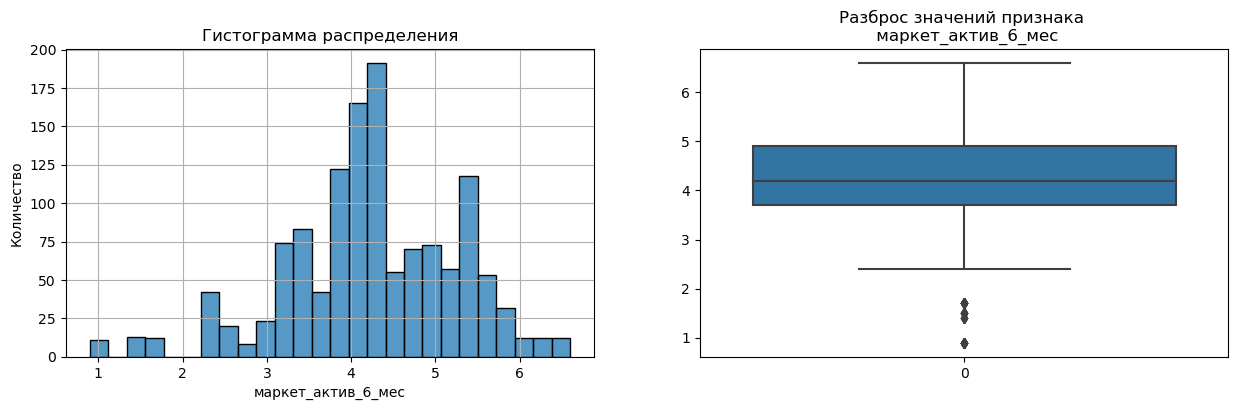

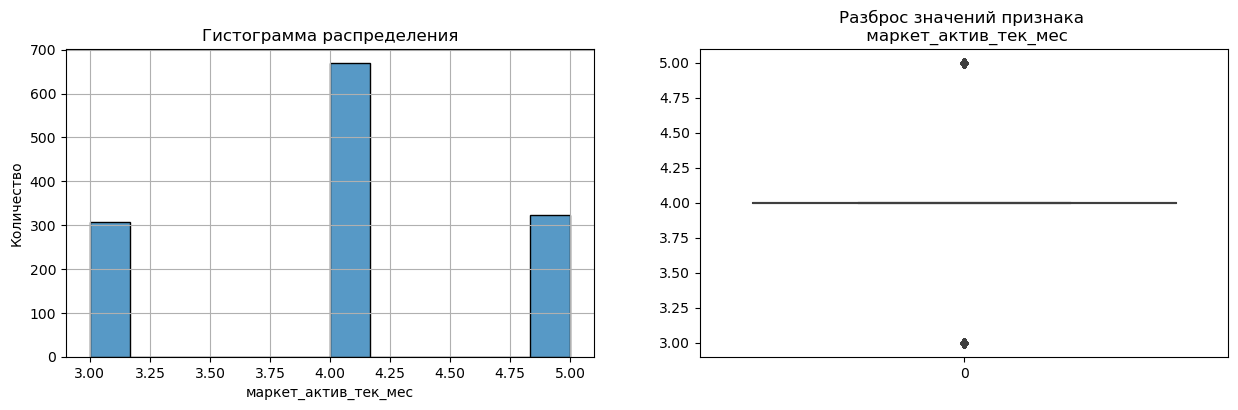

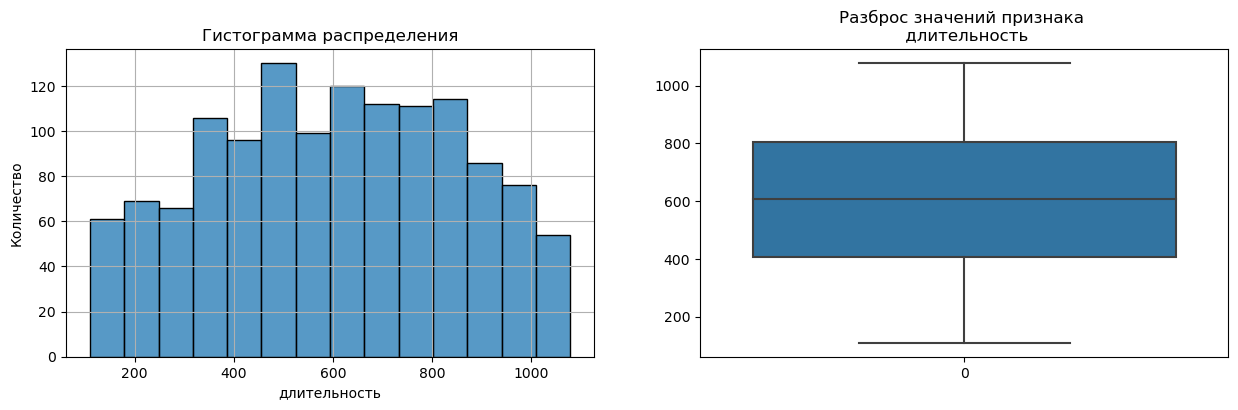

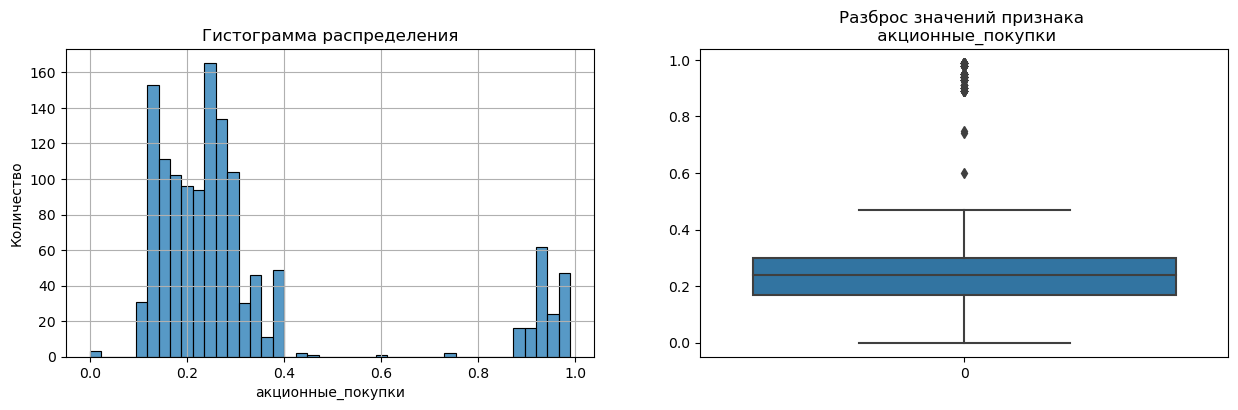

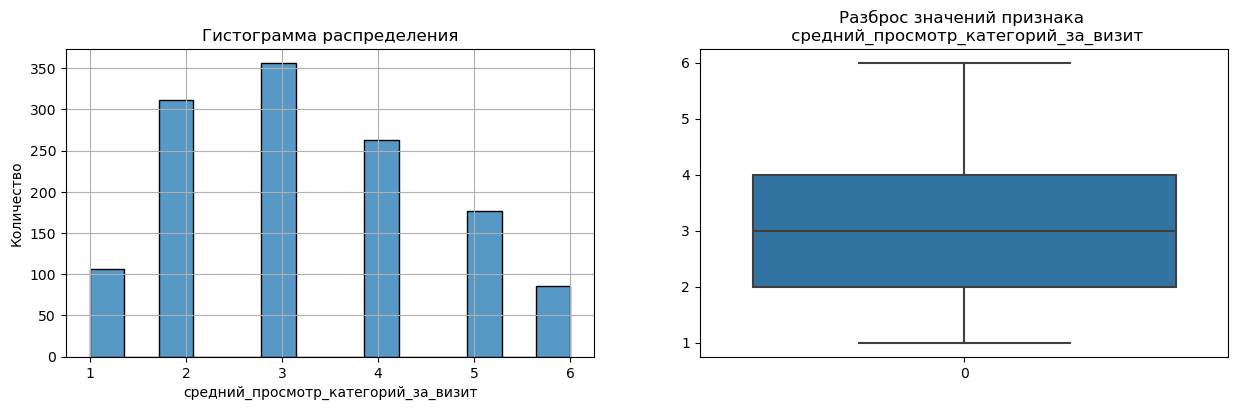

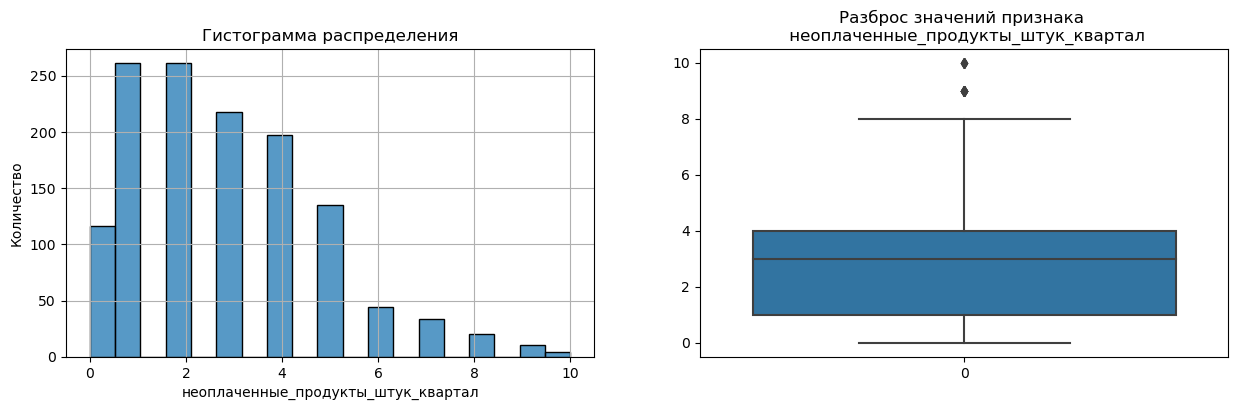

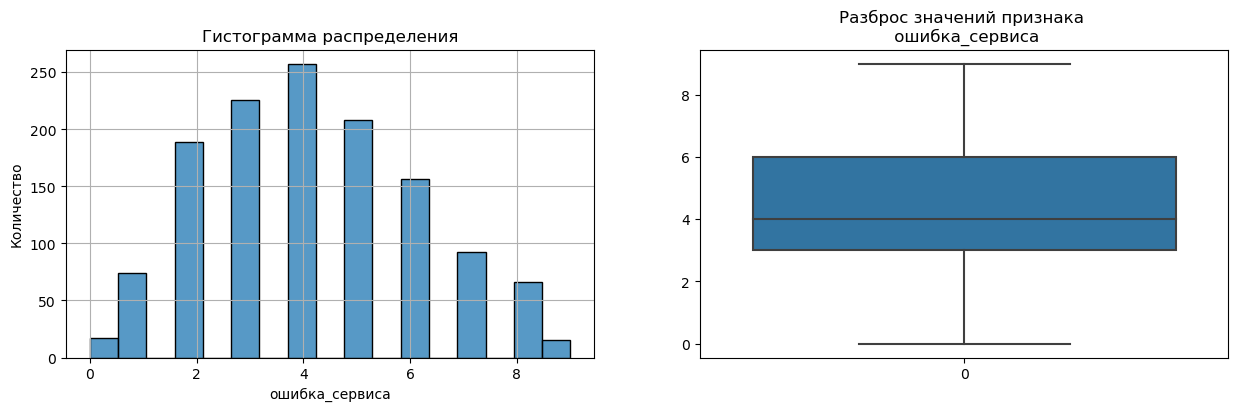

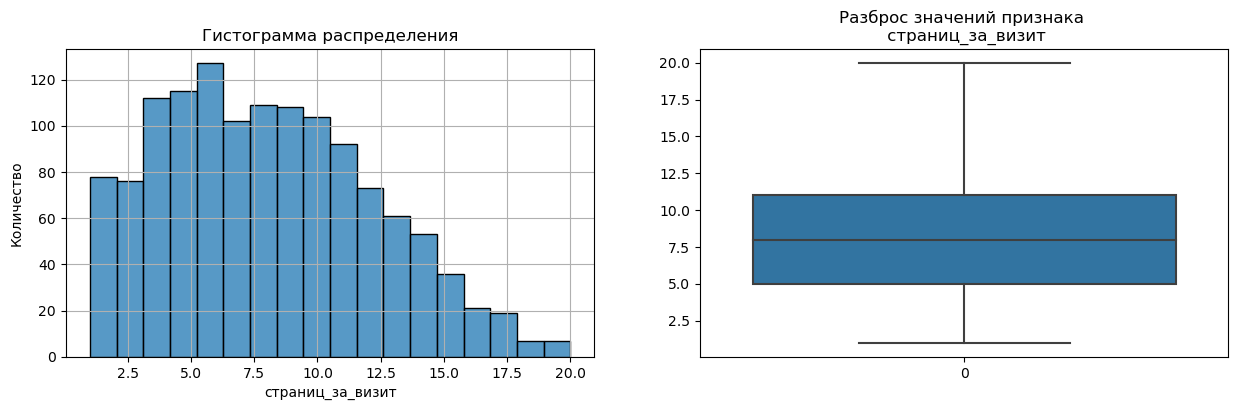

In [31]:
# Определяем список количественных признаков
numeric_market = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 
                      'длительность', 'акционные_покупки', 
                      'средний_просмотр_категорий_за_визит', 
                      'неоплаченные_продукты_штук_квартал', 
                      'ошибка_сервиса', 'страниц_за_визит']

# Применим созданную нами функцию к датафрейму market
for column in numeric_market:    
    plot_hist_box(market, column)

Из полученных графиков видно, что данные столбца 'Акционные_покупки' имеют два пика на гистограмме от примерно 0,1 до 0,4 и второй от примерно 0,85 до 1,0. Выбросы отсутствуют.

Построим бар-диаграммы для категориальных признаков датафрейма market

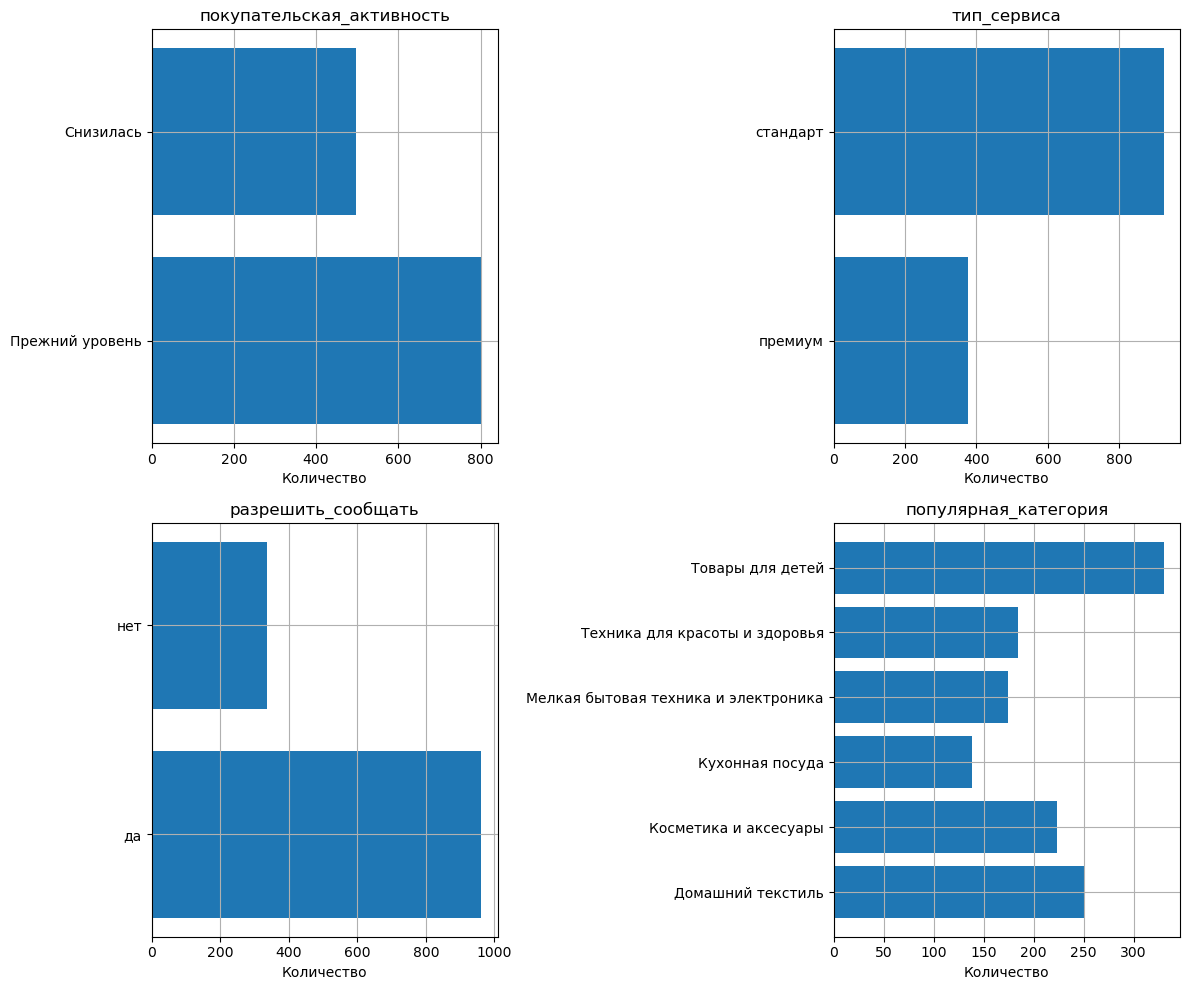

In [32]:
# Определим список категориальных признаков
cat_list_market = ['покупательская_активность',
               'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

# для удобства выделем эти столбцы в отдельный датафрейм 
cat_market = market[cat_list_market]

fig, axs = plt.subplots(2, 2, figsize = (12, 10))
axs = axs.ravel()

# зададим количество графиков и их расположение в три столбца
for i, column in enumerate(cat_market.columns):
    axs[i].barh(cat_market.groupby(column)[column].count().index, 
               cat_market.groupby(column)[column].count().values)
    axs[i].set_xlabel('Количество')
    axs[i].set_title(f'{column}')
    axs[i].grid()

plt.tight_layout() 
plt.show()    

Анализ гистограмм показал, следующее:
1. Покупательская способность снизилась примерно у 2/3 покупателей.
2. 1/3 покупателей имеют тип Премиум.
3. Наиболее популярной категорией товаров являются товары для детей, затем домашний текстиль, и далее - косметика и аксессуары и техника для красоты и здоровья. Наименьшим спросом пользуется кухонная посуда.

#### Проведем исследовательский анализ данных датафрейма market_money_pivot

In [33]:
# Описание числовых столбцов датафрейма market_money_pivot
market_money_pivot.describe()

id  выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
count    1300.000000               1300.000000                  1300.000000   
mean   215997.500000               4936.920385                  4825.206923   
std       375.421985                739.597997                   405.979663   
min    215348.000000                  0.000000                     0.000000   
25%    215672.750000               4496.750000                  4583.000000   
50%    215997.500000               5005.000000                  4809.000000   
75%    216322.250000               5405.625000                  5053.500000   
max    216647.000000               6869.500000                  5663.000000   

       выручка_текущий_месяц  
count            1300.000000  
mean             5314.960846  
std              2939.708156  
min              2758.700000  
25%              4706.050000  
50%              5179.950000  
75%              5761.725000  
max            106862.200000

Построим гистограммы и boxplot для количественных признаков датафрейма market_money_pivot

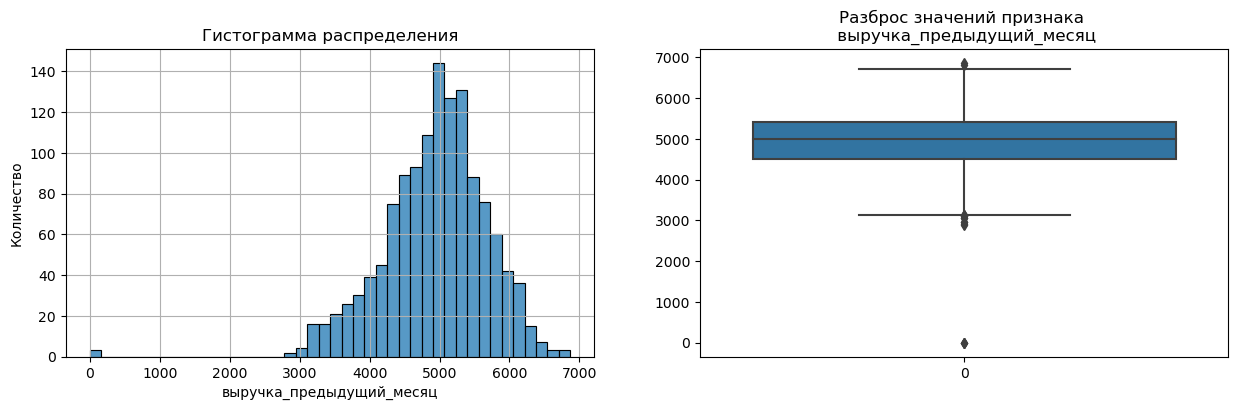

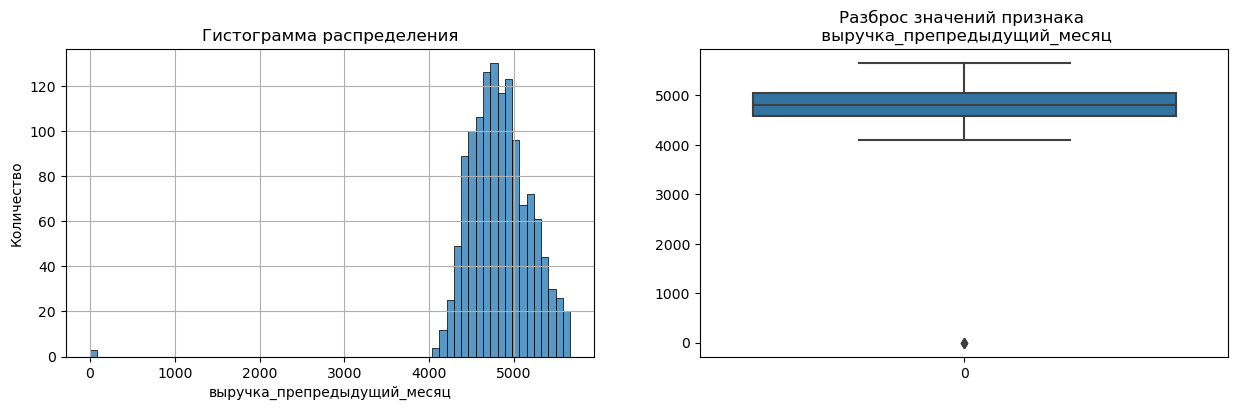

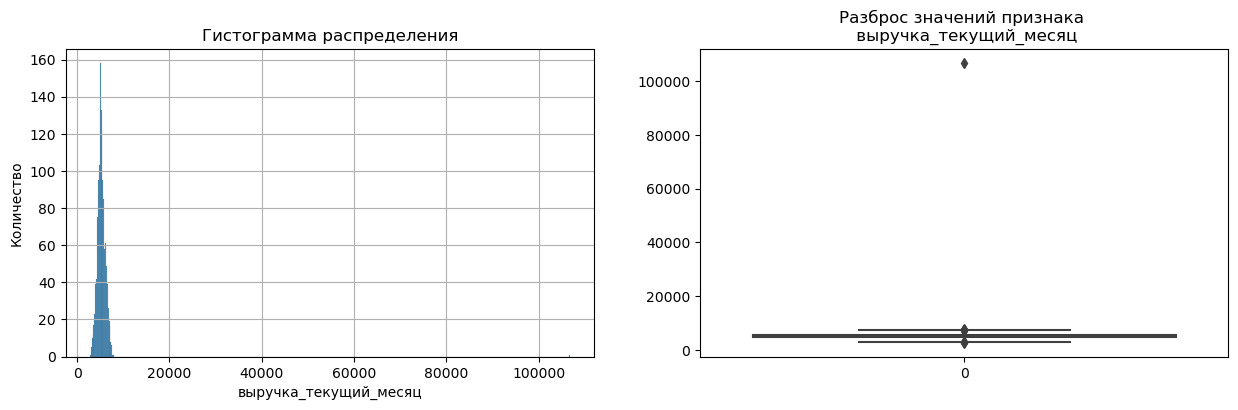

In [34]:
# Определяем список количественных признаков
num_market_money_pivot = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц',
       'выручка_текущий_месяц']

# Применим созданную нами функцию к датафрейму market_money
for column in num_market_money_pivot:    
    plot_hist_box(market_money_pivot, column)

Имеется один выброс с выручкой больше 100000 рублей.

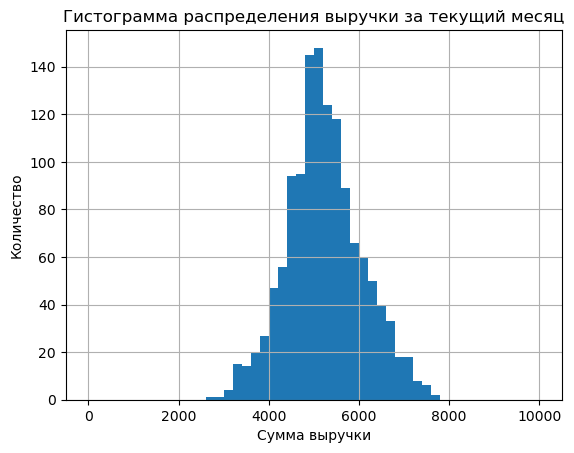

In [35]:
# Построим гистограмму распределения выручки за текущий период для диапазона 0-10000 руб.
plt.hist(market_money_pivot['выручка_текущий_месяц'], bins = 50, range = (0, 10000))
plt.title('Гистограмма распределения выручки за текущий месяц')
plt.ylabel('Количество')
plt.xlabel('Сумма выручки')
plt.grid()
plt.show();

Анализ графиков датафрейма market_money показал наличие выброса, который был удален из датафрейма для дальнейшего анализа.

#### Проведем исследовательский анализ данных датафрейма market_time_pivot

In [36]:
# Описание числовых столбцов датафрейма market_time_pivot
market_time_pivot.describe()

id  минут_предыдущий_месяц  минут_текущий_месяц
count    1300.000000             1300.000000          1300.000000
mean   215997.500000               13.467692            13.204615
std       375.421985                3.932029             4.220589
min    215348.000000                5.000000             4.000000
25%    215672.750000               11.000000            10.000000
50%    215997.500000               13.000000            13.000000
75%    216322.250000               17.000000            16.000000
max    216647.000000               23.000000            23.000000

Построим гистограммы и boxplot для количественных признаков датафрейма market_time_pivot

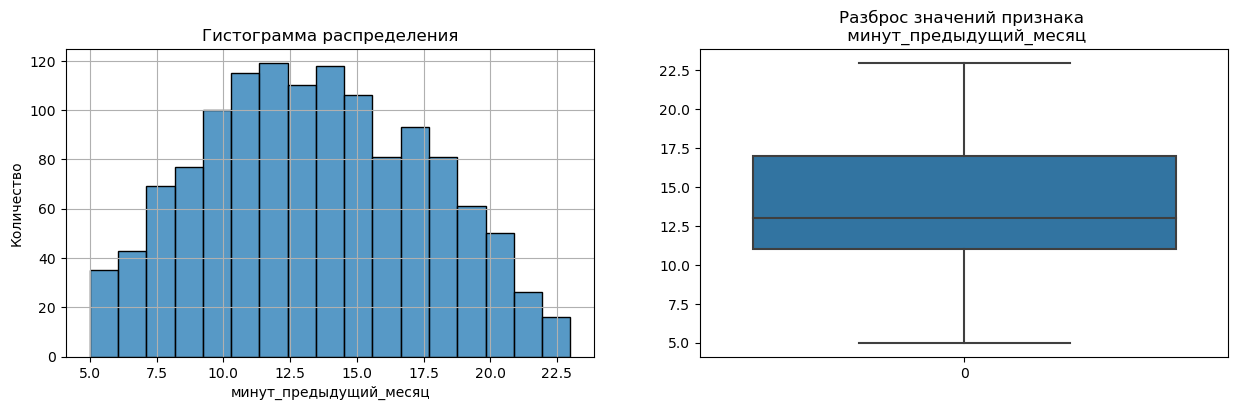

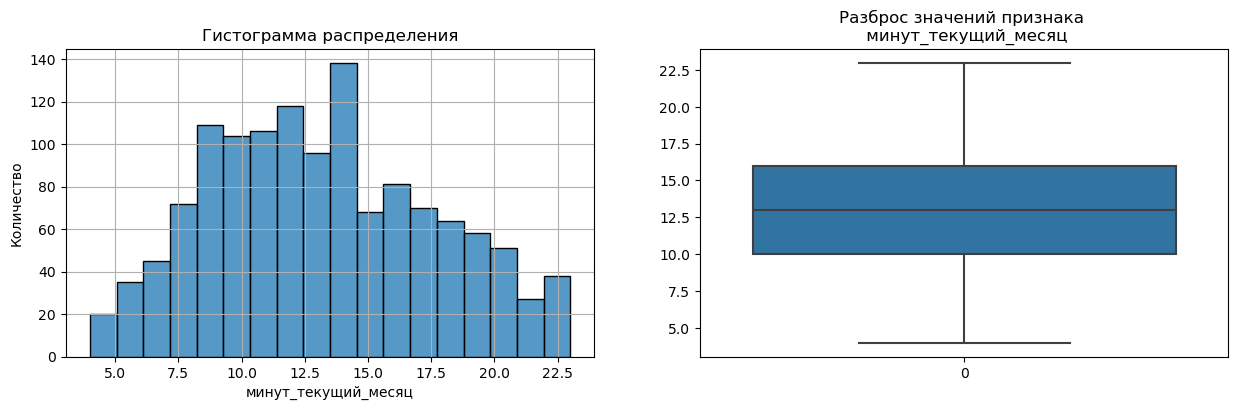

In [37]:
# Определяем список количественных признаков
num_market_time_pivot = ['минут_предыдущий_месяц', 'минут_текущий_месяц']

# Применим созданную нами функцию к датафрейму market_money
for column in num_market_time_pivot:    
    plot_hist_box(market_time_pivot, column)

Построим бар-диаграммы для категориальных признаков датафрейма market_time

Гистограмма распределения времени пребывания на сайте имеет практически нормальное распределение. Выбросы отсутствуют.

#### Проведем исследовательский анализ данных датафрейма money

In [38]:
# Описание числовых столбцов датафрейма market
money.describe()

id      прибыль
count    1300.000000  1300.000000
mean   215997.500000     3.996631
std       375.421985     1.013722
min    215348.000000     0.860000
25%    215672.750000     3.300000
50%    215997.500000     4.045000
75%    216322.250000     4.670000
max    216647.000000     7.430000

Построим гистограммы и boxplot для количественных признаков датафрейма money

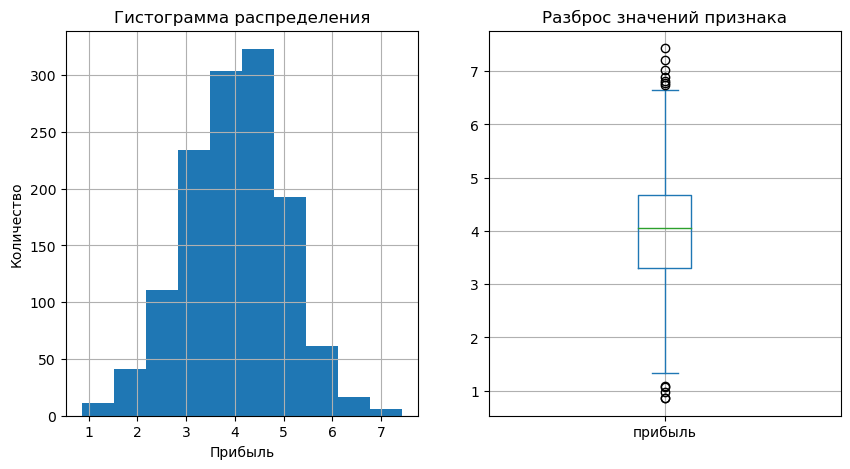

In [39]:
# Построим графики по количественным признакам датафрейма money:
# гистограмму частотности распределения и ящик с усами.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

money['прибыль'].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
axes[0].grid()
axes[0].set_ylabel('Количество')
axes[0].set_xlabel('Прибыль')
money['прибыль'].plot(kind='box',   ax=axes[1])
axes[1].set_title('Разброс значений признака')
axes[1].grid()

plt.show()

Гистограмма распределения немного скошена вправо. Выбросы отсутствуют.

Объединим датафреймы, кроме датафрейма market_money. Для этого во всех датафреймах сделаем столбец 'id' индексом.

In [40]:
market = market.set_index('id')
market_money_pivot = market_money_pivot.set_index('id')
market_time_pivot = market_time_pivot.set_index('id')
money = money.set_index('id')

In [41]:
# Объединим датафреймы. Для этого используем функцию pd.concat(), которая объединяет по индексу
market_merged = pd.concat([market, 
                           market_money_pivot, market_time_pivot], axis =1)
market_merged.head(3)

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215348                 Снизилась     премиум                 да   
215349                 Снизилась     премиум                 да   
215350                 Снизилась    стандарт                нет   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215348                 3.4                     5           121   
215349                 4.4                     4           819   
215350                 4.9                     3           539   

        акционные_покупки популярная_категория  \
id                                               
215348               0.00     Товары для детей   
215349               0.75     Товары для детей   
215350               0.14    Домашний текстиль   

        средний_просмотр_категорий_за_визит  \
id                                            
215348                                    6   
215349                                    4   
215350                                    5   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215348                                   2               1                 5   
215349                                   4               2                 5   
215350                                   2               1                 5   

        выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
id                                                              
215348                       0.0                          0.0   
215349                    5216.0                       4472.0   
215350                    5457.5                       4826.0   

        выручка_текущий_месяц  минут_предыдущий_месяц  минут_текущий_месяц  
id                                                                          
215348                 3293.1                      13                   14  
215349                 4971.6                      12                   10  
215350                 5058.4                       8                   13

In [42]:
market_merged.shape

(1300, 17)

In [43]:
# Отберем категорию покупателей с активностью не менее 3 месяцов
market_merged_active = market_merged.query(
    '(выручка_предыдущий_месяц >0) & (выручка_препредыдущий_месяц >0) & (выручка_текущий_месяц >0)'
)
market_merged_active.shape

(1297, 17)

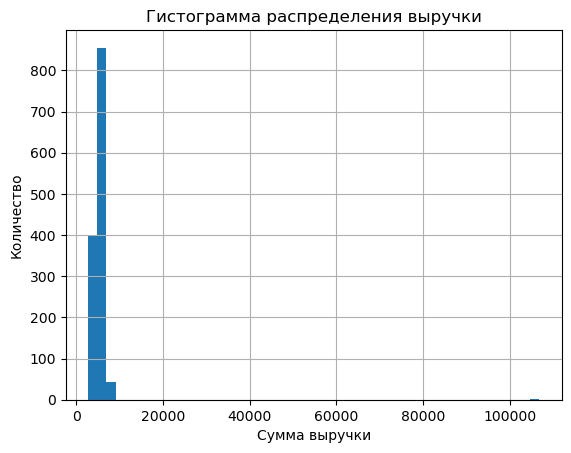

In [44]:
# Построим гистограмму распределения выручки за текущий период 
plt.hist(market_merged_active['выручка_текущий_месяц'], bins = 50)
plt.title('Гистограмма распределения выручки')
plt.ylabel('Количество')
plt.xlabel('Сумма выручки')
plt.grid()
plt.show(); 

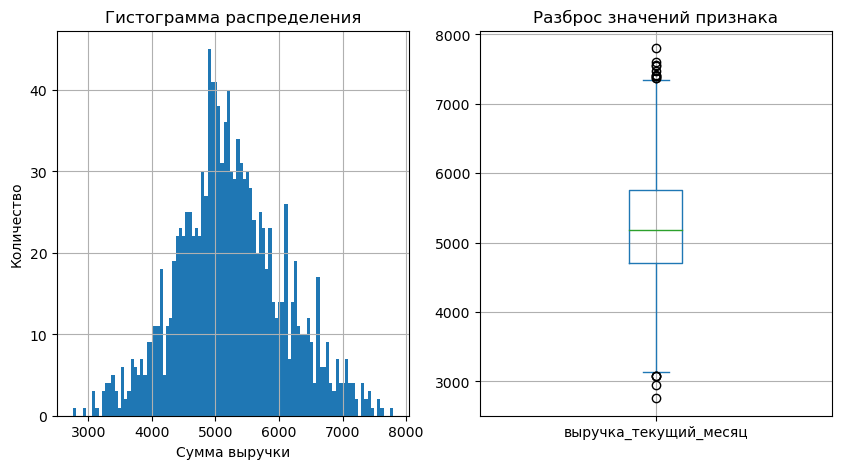

In [45]:
# Удалим выброс
market_merged_active = market_merged_active.query('выручка_текущий_месяц < 100000')

# check
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

market_merged_active['выручка_текущий_месяц'].plot(kind='hist', bins=100, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
axes[0].grid()
axes[0].set_ylabel('Количество')
axes[0].set_xlabel('Сумма выручки')
market_merged_active['выручка_текущий_месяц'].plot(kind='box',   ax=axes[1])
axes[1].set_title('Разброс значений признака')
axes[1].grid()

plt.show()

Выполнен исследовательский анализ каждого датафрейма. Выбросы отсутствуют, кроме данных по выручке за текущий месяц, где был выявлен один выброс. Для дальнейшего анализа выброс был удален.
Выделена категория активных покупателей (не менее трех месяцев). Количество новых покупателей (выручка только за текущий месяц) равно 3, остальные (1297) покупатели являются постоянными клиентами в течение по меньшей мере 3 месяцев.

In [46]:
market_merged_active.shape

(1296, 17)

## Корреляционный анализ данных

Для корреляционного анализа используем коэффициент корреляции ϕ, позволяющий определить корреляцию между любыми типами признаков. 

In [47]:
# список интервальных признаков
interval_cols = [
    'маркет_актив_6_мес',
    'акционные_покупки',
    'выручка_предыдущий_месяц',
    'выручка_препредыдущий_месяц',
    'выручка_текущий_месяц']

In [48]:
# считаем корреляции на тренировочной выборке
phik_overview = market_merged_active.phik_matrix(interval_cols=interval_cols)
print(phik_overview.shape) 

(17, 17)


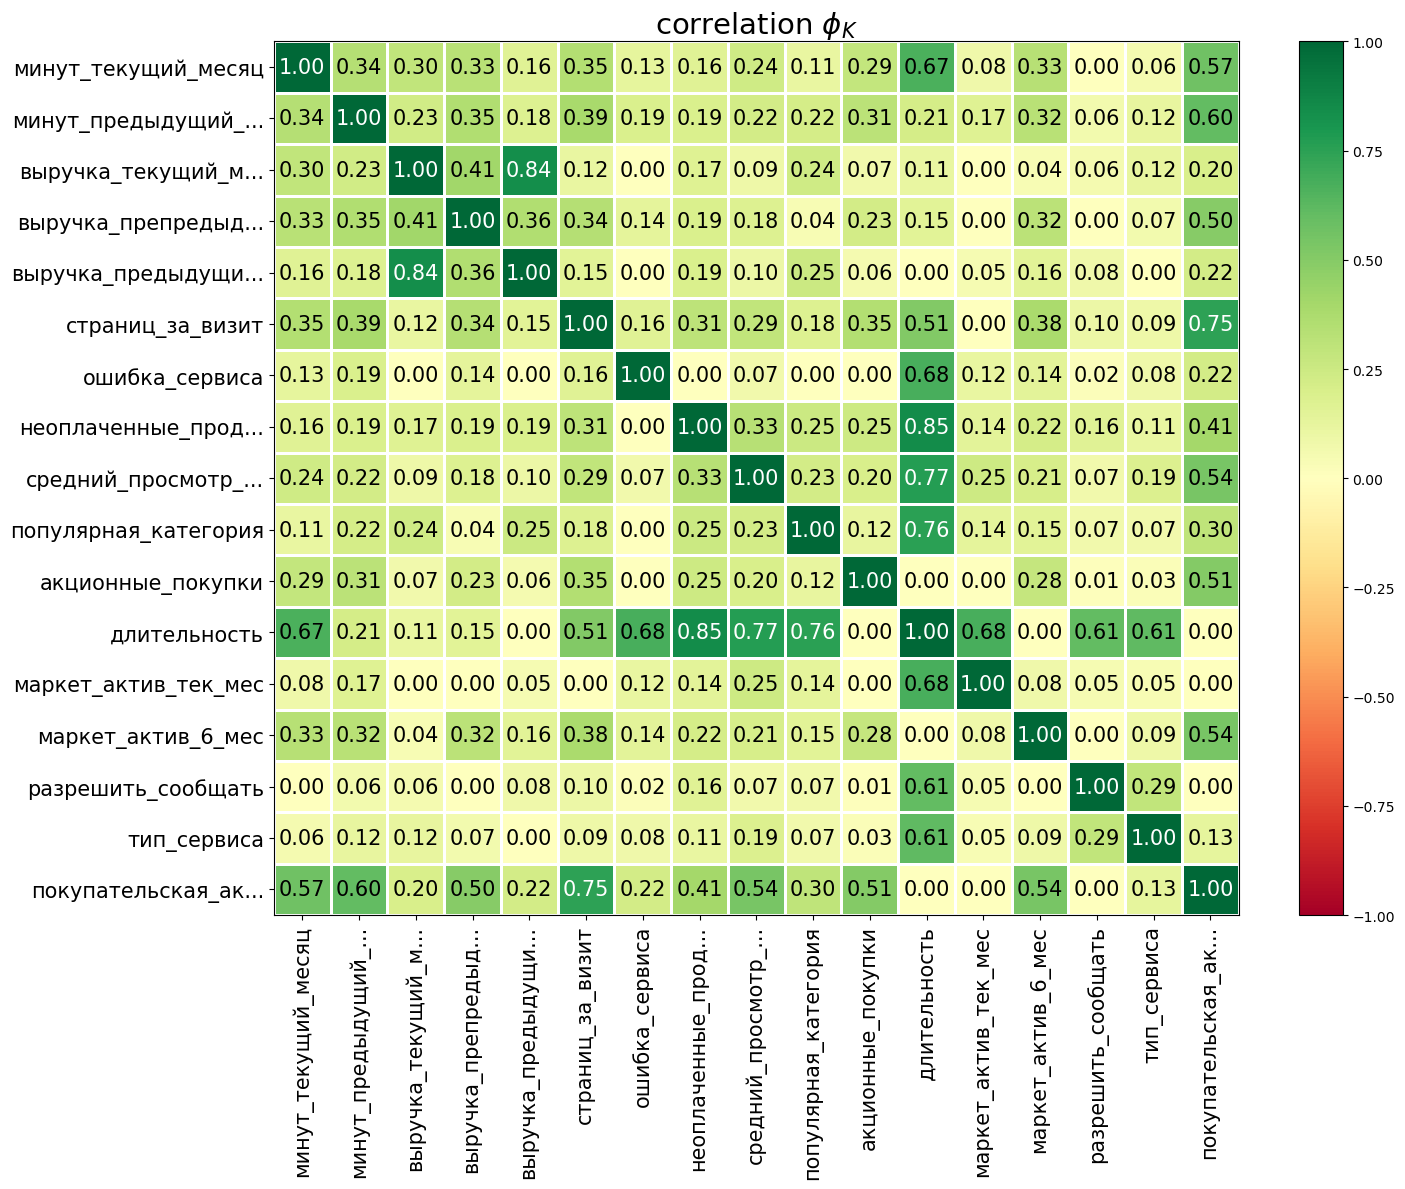

In [49]:
# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

Как видно их полученной таблицы, мультиколлинеарность отсутствует. Наибольшая корреляция признака  'покупательская_активность' наблюдается с признаками 'страниц_за_визит' (0,75), 'минут_предыдущий_месяц' (0,60), 'минут_текущий_месяц' (0,57), 'маркет_актив_6_мес' (0,54), 'средний_просмотр_категорий_за_визит' (0,54), 'аукционные_покупки' (0,51) и 'выручка_предыдущий_месяц' (0,50). Между остальными признаками коэффицинт корреляции ниже 0.5.

## Использование пайплайнов

В нашем случае стоит использовать метрику ROC-AUC, которая позволяет оценить качество работы модели вне зависимости от выбранного порога вероятности, при этом эту метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими, а это как раз наш случай.

Создадим пайплан для выбора наилучшей модели для предсказания клиентов со сниженной активностью.

In [50]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

# разбиваем данные на выборки

X_train, X_test, y_train, y_test = train_test_split(
    market_merged_active.drop(['покупательская_активность'], axis=1),
    market_merged_active['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_merged_active['покупательская_активность'])

X_train.shape, X_test.shape

# создаём списки с названиями признаков
ohe_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
num_columns = [
    'маркет_актив_6_мес', 
    'маркет_актив_тек_мес', 
    'длительность', 
    'акционные_покупки', 
    'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит',
    'выручка_предыдущий_месяц',
    'выручка_препредыдущий_месяц',
    'выручка_текущий_месяц',
    'минут_предыдущий_месяц',
    'минут_текущий_месяц']

# создаём пайплайн для подготовки признака 'покупательская_активность' для y_train и y_test:
# заполнение пропусков 
ordinal_encoder_ordered = OrdinalEncoder(
    categories=[
        ['Прежний уровень', 'Снизилась', 'Отсутствует']
    ],
    handle_unknown='use_encoded_value', unknown_value=np.nan
) 

y_train = ordinal_encoder_ordered.fit_transform(y_train.values.reshape(-1,1)).ravel()
y_test_ord = ordinal_encoder_ordered.transform(y_test.values.reshape(-1,1)).ravel()


# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier(weights='distance')],
        'models__n_neighbors': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, class_weight='balanced')],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, class_weight='balanced',
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

# Определим метрику f1-scorer
f1_scorer = make_scorer(f1_score, average = 'weighted')

# Определим метрики scorers
scoring = {
    'f1_score': make_scorer(f1_score, average='weighted', response_method='predict'),
    'roc_auc': make_scorer(roc_auc_score, average='weighted', response_method=None),
    'accuracy': make_scorer(accuracy_score, response_method='predict')
}
    
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=scoring,
    refit='f1_score',  # Выбираем ключевую метрику для refitting
    random_state=RANDOM_STATE,
    n_jobs=-1,

)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверяем работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_pred = randomized_search.predict(X_test)

print(f'Метрика F1 на тестовой выборке: {f1_score(y_test_ord, y_pred)}')

pos_label_encoded = 1
precision = precision_score(y_test_ord, y_pred, pos_label = pos_label_encoded)
recall = recall_score(y_test_ord, y_pred, pos_label = pos_label_encoded)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

ordinal_encoder_categories = ordinal_encoder_ordered.categories_[0]

for code, category in enumerate(ordinal_encoder_categories):
    print(f'Category "{category}" is encoded as {code}')

print(f'Category encoded as 1: {ordinal_encoder_ordered.categories_[0][1]}')
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_ord, y_pred)}')
print(f'Метрика ACCURACY на тестовой выборке: {accuracy_score(y_test_ord, y_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('num', StandardScaler(),
                                                  [

Лучшей моделью является LogisticRegression со следующими параметрами: C=1, class_weight='balanced', penalty='l1', solver='liblinear'.

## Анализ важности признаков

Проанализируем важность признаков для LogisticRegression(C=1, class_weight='balanced', max_iter=1000, penalty='l1', random_state=42, solver='liblinear')

In [51]:
# Определим финальный пайплан с лучшей предсказанной моделью 
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))
])

# Обучим модель
pipe_final.fit(X_train, y_train)

# проверяем работу модели
acc1 = accuracy_score(y_test_ord, pipe_final.predict(X_test))
print('метрика ACCURACY:', acc1)

probabilities = randomized_search.predict(X_test)
#probabilities_one = probabilities[:, 1]

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test_ord, probabilities)
print('Площадь ROC-кривой:', roc_auc_score(y_test_ord, probabilities))


метрика ACCURACY: 0.8796296296296297
Площадь ROC-кривой: 0.8673704647494235


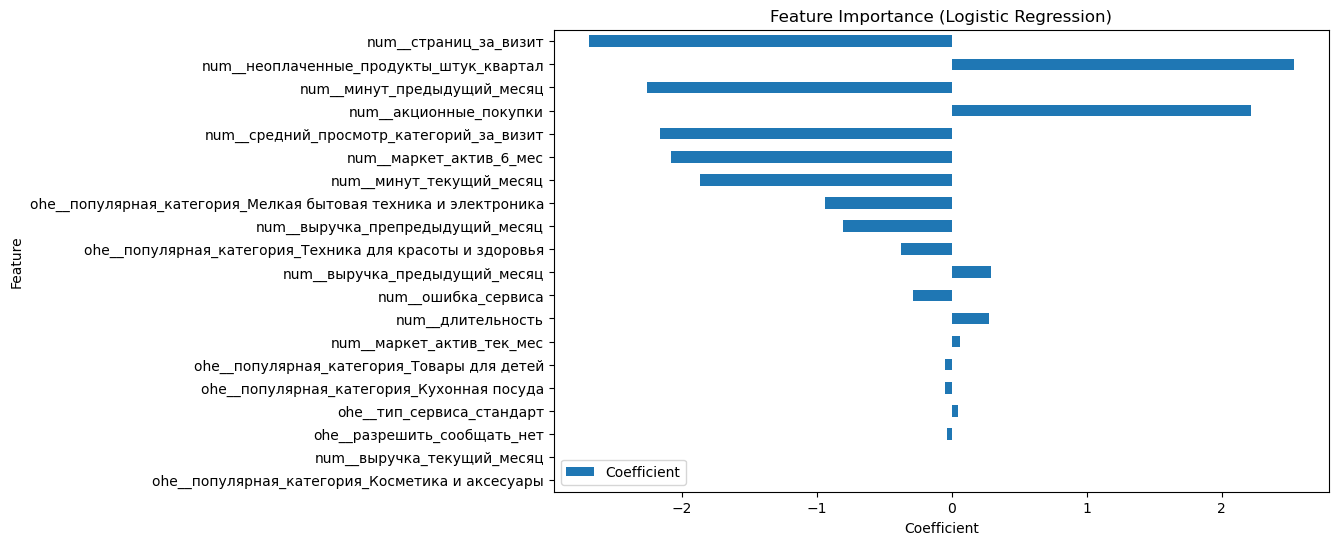

In [52]:
# Извлекаем лучшую модель из результатов рандомизированного поиска
best_model = pipe_final.named_steps['model']

# Check if the best model is Logistic Regression
if isinstance(best_model, LogisticRegression):
    # Extract coefficients from the best model
    coefficients = best_model.coef_[0]
    
    # Extract feature names after transformation
    feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
    
    # Create a DataFrame for feature importance
    feature_importance = pd.DataFrame({
            'Feature': feature_names, 
            'Coefficient': coefficients
        })
        
        # Sort the features by absolute coefficient values
    feature_importance['Absolute Coefficient'] = feature_importance['Coefficient'].abs()
    feature_importance = feature_importance.sort_values('Absolute Coefficient', ascending=True)
        
        # Plot the feature importance
    feature_importance.plot(x='Feature', y='Coefficient', kind='barh', figsize=(10, 6))
    plt.title("Feature Importance (Logistic Regression)")
    plt.xlabel("Coefficient")
    plt.ylabel("Feature")
    plt.show()
    
else:
    print("The best model is not a Logistic Regression model.")

Из графика важности признаков видно, что признак Мелкая бытовая техника является самым важным. При этом увеличение количества аукционных покупок и неоплаченных продуктов за квартал увеличивают вероятность отнесения покупателя к группе со сниженной покупательской активностью.  

Посмотрим на важность признаков по методу SHAP

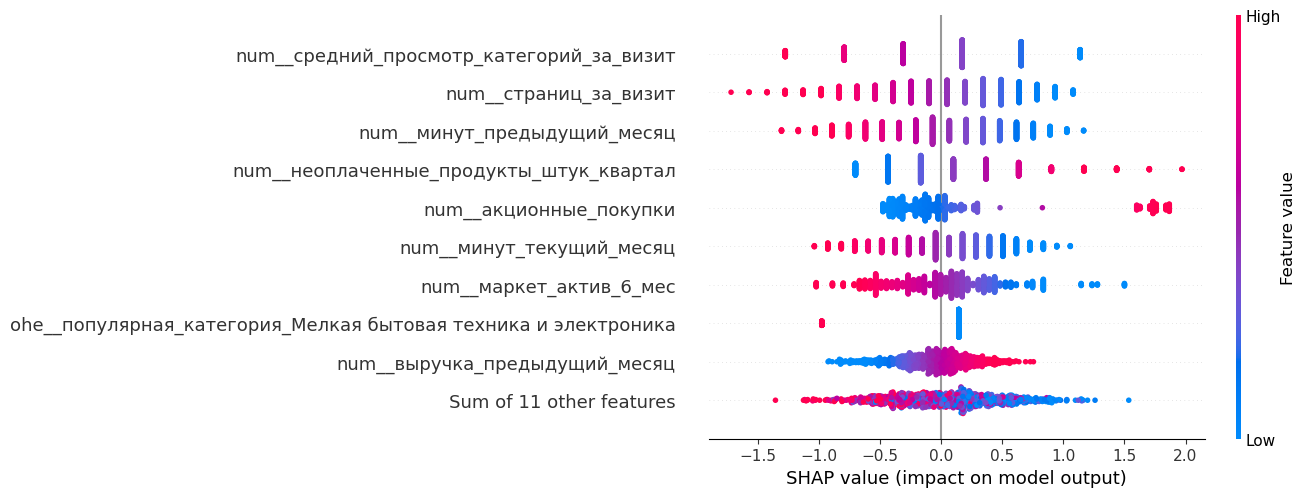

In [53]:
# Извлекаем лучшую метрику оценки из результатов рандомизированного поиска
best_estimator = randomized_search.best_estimator_
best_estimator.fit(X_train, y_train)

# Извлекаем лучшую модель из пайплана
final_model = best_estimator.named_steps['models']

# Извлекаем preprocessor из пайплана
preprocessor = best_estimator.named_steps['preprocessor']

# Трансформируем данные для обучения модели и вычисляем значения SHAP, используя preprocessor
X_train_transformed = preprocessor.transform(X_train)

# Инициализируем explainer, используя извлеченные модель и preprocessor
explainer = shap.Explainer(final_model, X_train_transformed)

# Вычисляем значения SHAP
shap_values = explainer.shap_values(X_train_transformed)

if hasattr(preprocessor, 'get_feature_names_out'):
    transformed_feature_names = preprocessor.get_feature_names_out()
    feature_mapping = {
        feature: feature.split('_')[0] if feature.startswith(tuple(ohe_columns)) else feature
        for feature in transformed_feature_names
    }
    original_feature_names = [feature_mapping[name] for name in transformed_feature_names]
else:
    # Если названия признаков не могут быть извлечены, используем номера
    original_feature_names = [f'Feature {i}' for i in range(X_train_transformed.shape[1])]

# Создвем объект SHAP Explanation
new_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_train_transformed, 
    feature_names=original_feature_names
)

# Отображаем значения SHAP на графике
shap.plots.beeswarm(new_explanation)

Из графика видно, что чем больше количество просмотренные страниц за визит, тем более вероятность отнесения поведения покупателя к классу 0 ("Прежний уровень"), то же самое можно сказать о количестве минут за предыдущий месяц. Увеличение количества неоплаченных продуктов увеличивает вероятность отнесения к классу 1 ("Снизилась"), аналогично и количество приобретенных аукционных товаров.

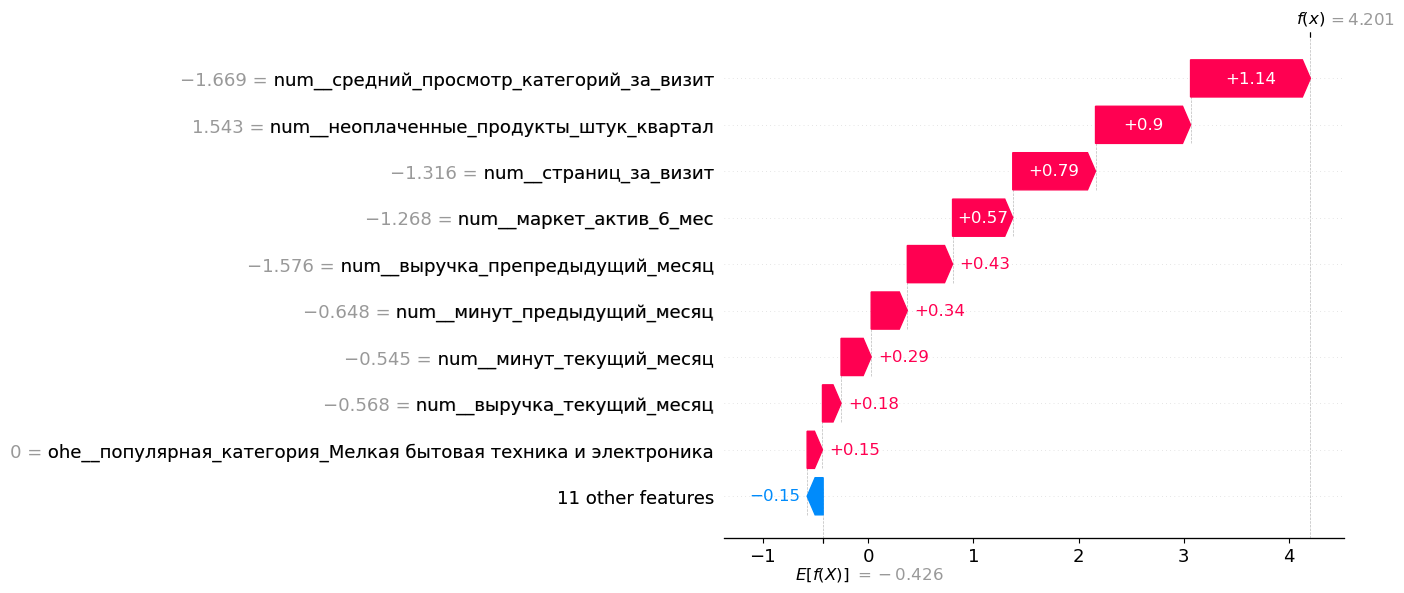

In [54]:
# Оценим вклад каждого признака на примере покупателя 6
shap.plots.waterfall(new_explanation[6]) 

Покупательская активность этого клиента зависит от среднего просмотра категорий за визит, неоплаченных продуктов и количества просмотренных страниц за визит, которые увеличивают вероятность его отнесения к классу 1 ("Снизилась").

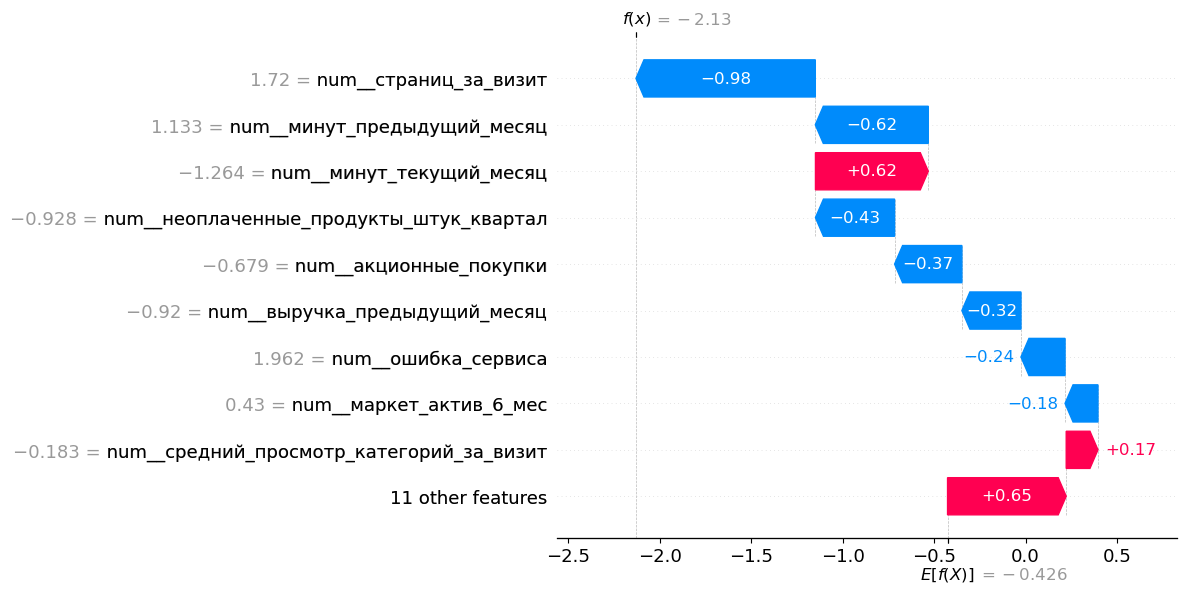

In [55]:
# Оценим вклад каждого признака на примере покупателя 208
shap.plots.waterfall(new_explanation[208]) 

Для этого покупателя важноыми являются признаки: количество просмотренных страниц за визит, количество минут за предыдущий месяц и количество неоплаченных продуктов, которые увеличивают вероятность его отнесения его к классу  0 ("Прежний уровень"). Признак - количество минут в текущем месяце - увеличивает вероятность его отнесения к классу 1.

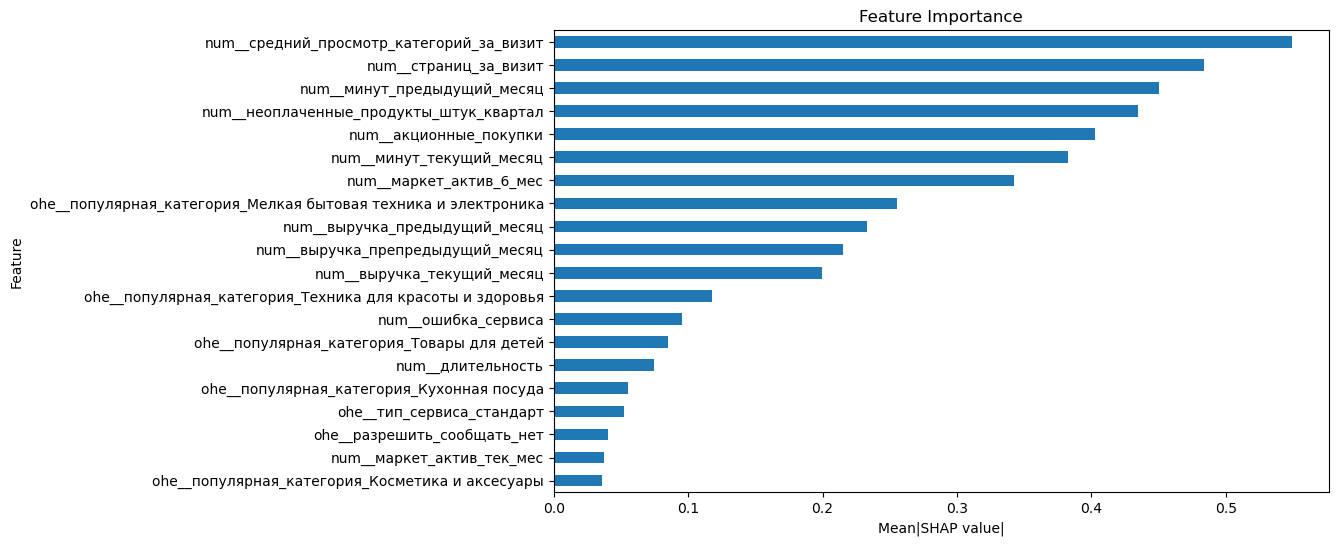

In [56]:
# Посмотрим на график общей значимости признаков
shap_sum = np.abs(new_explanation.values).mean(axis = 0)
shap_series = pd.Series(shap_sum, index = original_feature_names)

shap_series =shap_series.sort_values(ascending = True)

plt.figure(figsize = (10, 6))
shap_series.plot(kind = 'barh')
plt.title('Feature Importance')
plt.ylabel('Feature')
plt.xlabel('Mean|SHAP value|')
plt.show()

Важными признаками для предсказания активности клиента являются: средний просмотр категорий за визит, количество страниц за визит, минут в предыдущий месяц, количество неоплаченных продуктов, аукционные покупки, минут в текущем месяце и активный маркетинг за 6 месяцев. Важной категорией является мелкая бытовая техника и электроника.

## Сегментация покупателей

In [57]:
# Объединим датафреймы market_merged и money. 
# Для этого используем функцию pd.concat(), которая объединяет по индексу
market_money = market_merged.merge(money, on = 'id', how = 'inner')
market_money.head(3)
print(market_money.shape)

(1300, 18)


In [58]:
# Создадим датафрейм из тестовой выборки и предсказанной для нее вероятности снижения активности
df_y_test = pd.DataFrame(y_test)
df_y_test['probabilities'] = probabilities
df_y_test.head()

покупательская_активность  probabilities
id                                             
216161           Прежний уровень            0.0
215654                 Снизилась            1.0
216307           Прежний уровень            0.0
215501                 Снизилась            1.0
215934                 Снизилась            1.0

In [59]:
# Дополним полученный датафрейм остальными признаками
df_y_test_merged = df_y_test.merge(market_money, on = 'id', how = 'inner')
df_y_test_merged.head()

покупательская_активность_x  probabilities покупательская_активность_y  \
id                                                                              
216161             Прежний уровень            0.0             Прежний уровень   
215654                   Снизилась            1.0                   Снизилась   
216307             Прежний уровень            0.0             Прежний уровень   
215501                   Снизилась            1.0                   Снизилась   
215934                   Снизилась            1.0                   Снизилась   

       тип_сервиса разрешить_сообщать  маркет_актив_6_мес  \
id                                                          
216161    стандарт                 да                 4.1   
215654     премиум                нет                 1.4   
216307     премиум                 да                 3.3   
215501     премиум                 да                 3.5   
215934    стандарт                нет                 5.5   

        маркет_актив_тек_мес  длительность  акционные_покупки  \
id                                                              
216161                     4           606               0.15   
215654                     4           684               0.94   
216307                     4           488               0.13   
215501                     3          1057               0.35   
215934                     4           147               0.99   

                        популярная_категория  \
id                                             
216161        Техника для красоты и здоровья   
215654                      Товары для детей   
216307                     Домашний текстиль   
215501                     Домашний текстиль   
215934  Мелкая бытовая техника и электроника   

        средний_просмотр_категорий_за_визит  \
id                                            
216161                                    6   
215654                                    3   
216307                                    4   
215501                                    4   
215934                                    1   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
216161                                   1               4                12   
215654                                   6               1                 6   
216307                                   2               8                10   
215501                                   3               5                 6   
215934                                   2               3                 7   

        выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
id                                                              
216161                    3973.0                       4912.0   
215654                    3548.0                       4656.0   
216307                    5444.0                       4565.0   
215501                    6604.0                       4993.0   
215934                    5090.0                       4451.0   

        выручка_текущий_месяц  минут_предыдущий_месяц  минут_текущий_месяц  \
id                                                                           
216161                 3289.2                      16                   17   
215654                 4170.7                      11                    9   
216307                 6335.8                      20                   11   
215501                 6758.7                       9                    9   
215934                 5773.8                      15                   18   

        прибыль  
id               
216161     4.69  
215654     2.75  
216307     3.16  
215501     3.74  
215934     4.40

In [60]:
print(y_test)

id
216161    Прежний уровень
215654          Снизилась
216307    Прежний уровень
215501          Снизилась
215934          Снизилась
               ...       
215429          Снизилась
216233    Прежний уровень
215716          Снизилась
216141    Прежний уровень
215670          Снизилась
Name: покупательская_активность, Length: 324, dtype: object


In [61]:
market_money.head(2)

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215348                 Снизилась     премиум                 да   
215349                 Снизилась     премиум                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215348                 3.4                     5           121   
215349                 4.4                     4           819   

        акционные_покупки популярная_категория  \
id                                               
215348               0.00     Товары для детей   
215349               0.75     Товары для детей   

        средний_просмотр_категорий_за_визит  \
id                                            
215348                                    6   
215349                                    4   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215348                                   2               1                 5   
215349                                   4               2                 5   

        выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
id                                                              
215348                       0.0                          0.0   
215349                    5216.0                       4472.0   

        выручка_текущий_месяц  минут_предыдущий_месяц  минут_текущий_месяц  \
id                                                                           
215348                 3293.1                      13                   14   
215349                 4971.6                      12                   10   

        прибыль  
id               
215348     0.98  
215349     4.16

Выберем сектор с вероятностью 0,7 и выручкой = 2. Этот сектор включает набольшее количество клиентов с низкой потребительской активностью.

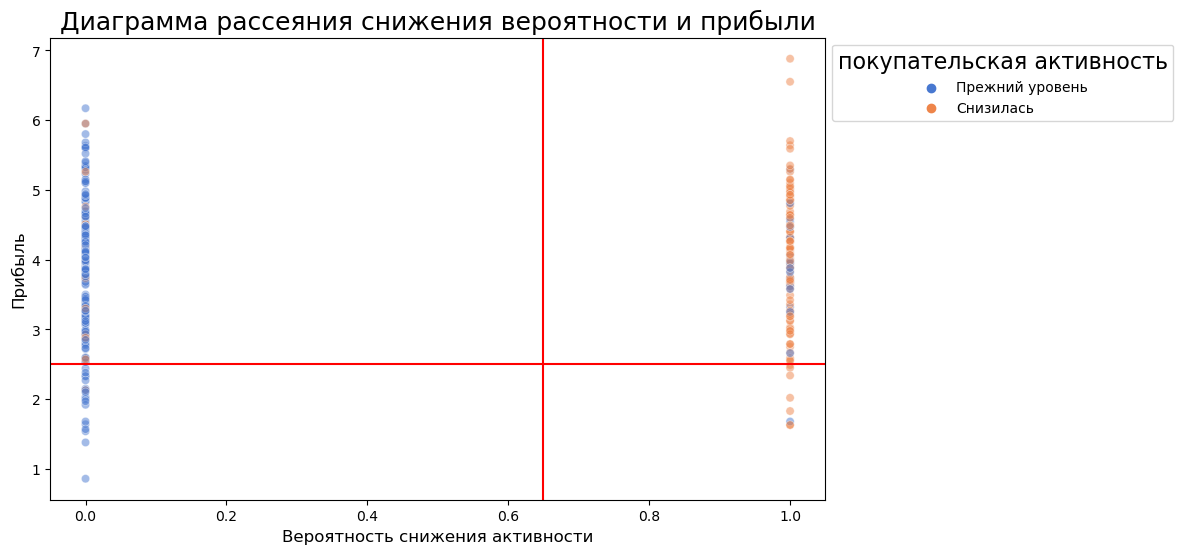

In [62]:
# Построим диаграмму рассеяния для вероятности снижения покупательской активности и прибыли
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_y_test_merged, x='probabilities', y='прибыль', 
                hue='покупательская_активность_y', alpha=0.5, palette='muted')

# Customizing the legend
plt.legend(title='покупательская активность', title_fontsize=16, 
           loc='upper left', bbox_to_anchor=(1.0, 1.0))

# Show the plot
plt.ylabel('Прибыль', fontsize=12)
plt.xlabel('Вероятность снижения активности', fontsize=12)
plt.title(f'Диаграмма рассеяния снижения вероятности и прибыли', 
        fontsize=18)
plt.axvline(x=0.65, color = 'red')
plt.axhline(y = 2.5, color = 'red')
plt.show()

In [63]:
df_y_test_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 324 entries, 216161 to 215670
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность_x          324 non-null    object 
 1   probabilities                        324 non-null    float64
 2   покупательская_активность_y          324 non-null    object 
 3   тип_сервиса                          324 non-null    object 
 4   разрешить_сообщать                   324 non-null    object 
 5   маркет_актив_6_мес                   324 non-null    float64
 6   маркет_актив_тек_мес                 324 non-null    int64  
 7   длительность                         324 non-null    int64  
 8   акционные_покупки                    324 non-null    float64
 9   популярная_категория                 324 non-null    object 
 10  средний_просмотр_категорий_за_визит  324 non-null    int64  
 11  неоплаченные_продукты_штук_кв

In [64]:
# Выделим покупателей, вошедших в этот сегмент в отдельный датафрейм
df_low_activity = df_y_test_merged[(
    df_y_test_merged.probabilities > 0.7) & (df_y_test_merged.прибыль >2)]

# Из оставштхся покупателей создадим второй датафрейм
df_unchanged_activity = df_y_test_merged[~df_y_test_merged.index.isin(df_low_activity.index)]


In [65]:
# check
print(df_low_activity.shape[0])
print(df_unchanged_activity.shape[0])
print(df_y_test_merged.shape[0])

117
207
324


Посмотрим на колтчественные признаки в обоих датаыреймах

In [66]:
# df_low_activity
df_low_activity.describe()

probabilities  маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count          117.0          117.000000            117.000000    117.000000   
mean             1.0            3.570085              4.008547    602.692308   
std              0.0            1.159464              0.675887    239.882351   
min              1.0            0.900000              3.000000    147.000000   
25%              1.0            2.600000              4.000000    433.000000   
50%              1.0            3.900000              4.000000    646.000000   
75%              1.0            4.300000              4.000000    800.000000   
max              1.0            6.300000              5.000000   1057.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count         117.000000                           117.000000   
mean            0.500769                             2.555556   
std             0.316473                             1.132928   
min             0.120000                             1.000000   
25%             0.250000                             2.000000   
50%             0.340000                             2.000000   
75%             0.930000                             3.000000   
max             0.990000                             6.000000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
count                          117.000000      117.000000        117.000000   
mean                             3.760684        3.726496          4.931624   
std                              1.972438        1.919159          2.893889   
min                              0.000000        0.000000          1.000000   
25%                              2.000000        2.000000          3.000000   
50%                              4.000000        3.000000          4.000000   
75%                              5.000000        5.000000          6.000000   
max                             10.000000        8.000000         18.000000   

       выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
count                117.000000                   117.000000   
mean                5033.905983                  4667.051282   
std                  770.753796                   247.781705   
min                 2960.000000                  4138.000000   
25%                 4657.000000                  4488.000000   
50%                 5130.500000                  4684.000000   
75%                 5529.500000                  4856.000000   
max                 6658.500000                  5612.000000   

       выручка_текущий_месяц  минут_предыдущий_месяц  минут_текущий_месяц  \
count             117.000000              117.000000           117.000000   
mean             5389.683761               10.145299            10.410256   
std               809.357111                3.017949             3.285690   
min              3078.300000                5.000000             4.000000   
25%              4834.100000                8.000000             8.000000   
50%              5484.800000               10.000000            10.000000   
75%              6034.700000               12.000000            13.000000   
max              7212.300000               18.000000            22.000000   

          прибыль  
count  117.000000  
mean     4.067778  
std      0.892198  
min      2.020000  
25%      3.490000  
50%      4.080000  
75%      4.690000  
max      6.880000

In [67]:
# df_unchanged_activity
df_unchanged_activity.describe()

probabilities  маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count     207.000000          207.000000            207.000000    207.000000   
mean        0.019324            4.581159              3.937198    584.342995   
std         0.137994            0.771446              0.654275    246.619107   
min         0.000000            2.600000              3.000000    129.000000   
25%         0.000000            4.000000              4.000000    401.000000   
50%         0.000000            4.400000              4.000000    582.000000   
75%         0.000000            5.200000              4.000000    782.000000   
max         1.000000            6.600000              5.000000   1061.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count         207.000000                           207.000000   
mean            0.228937                             3.768116   
std             0.136882                             1.316198   
min             0.110000                             1.000000   
25%             0.150000                             3.000000   
50%             0.210000                             4.000000   
75%             0.260000                             5.000000   
max             0.950000                             6.000000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
count                          207.000000      207.000000        207.000000   
mean                             2.154589        4.400966          9.961353   
std                              1.419444        1.987485          3.452655   
min                              0.000000        0.000000          1.000000   
25%                              1.000000        3.000000          8.000000   
50%                              2.000000        4.000000         10.000000   
75%                              3.000000        6.000000         12.000000   
max                              5.000000        9.000000         20.000000   

       выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
count                207.000000                   207.000000   
mean                4862.869565                  4916.985507   
std                  660.480667                   314.857179   
min                 3155.000000                  4346.000000   
25%                 4443.250000                  4669.000000   
50%                 4926.000000                  4921.000000   
75%                 5360.500000                  5154.500000   
max                 6165.500000                  5624.000000   

       выручка_текущий_месяц  минут_предыдущий_месяц  минут_текущий_месяц  \
count             207.000000              207.000000           207.000000   
mean             5146.558454               14.995169            14.512077   
std               808.051430                3.279086             4.219534   
min              2952.200000                7.000000             4.000000   
25%              4689.700000               12.500000            12.000000   
50%              5106.900000               15.000000            14.000000   
75%              5588.450000               17.000000            18.000000   
max              7370.600000               22.000000            23.000000   

          прибыль  
count  207.000000  
mean     3.816812  
std      1.043444  
min      0.860000  
25%      3.145000  
50%      3.890000  
75%      4.480000  
max      6.170000

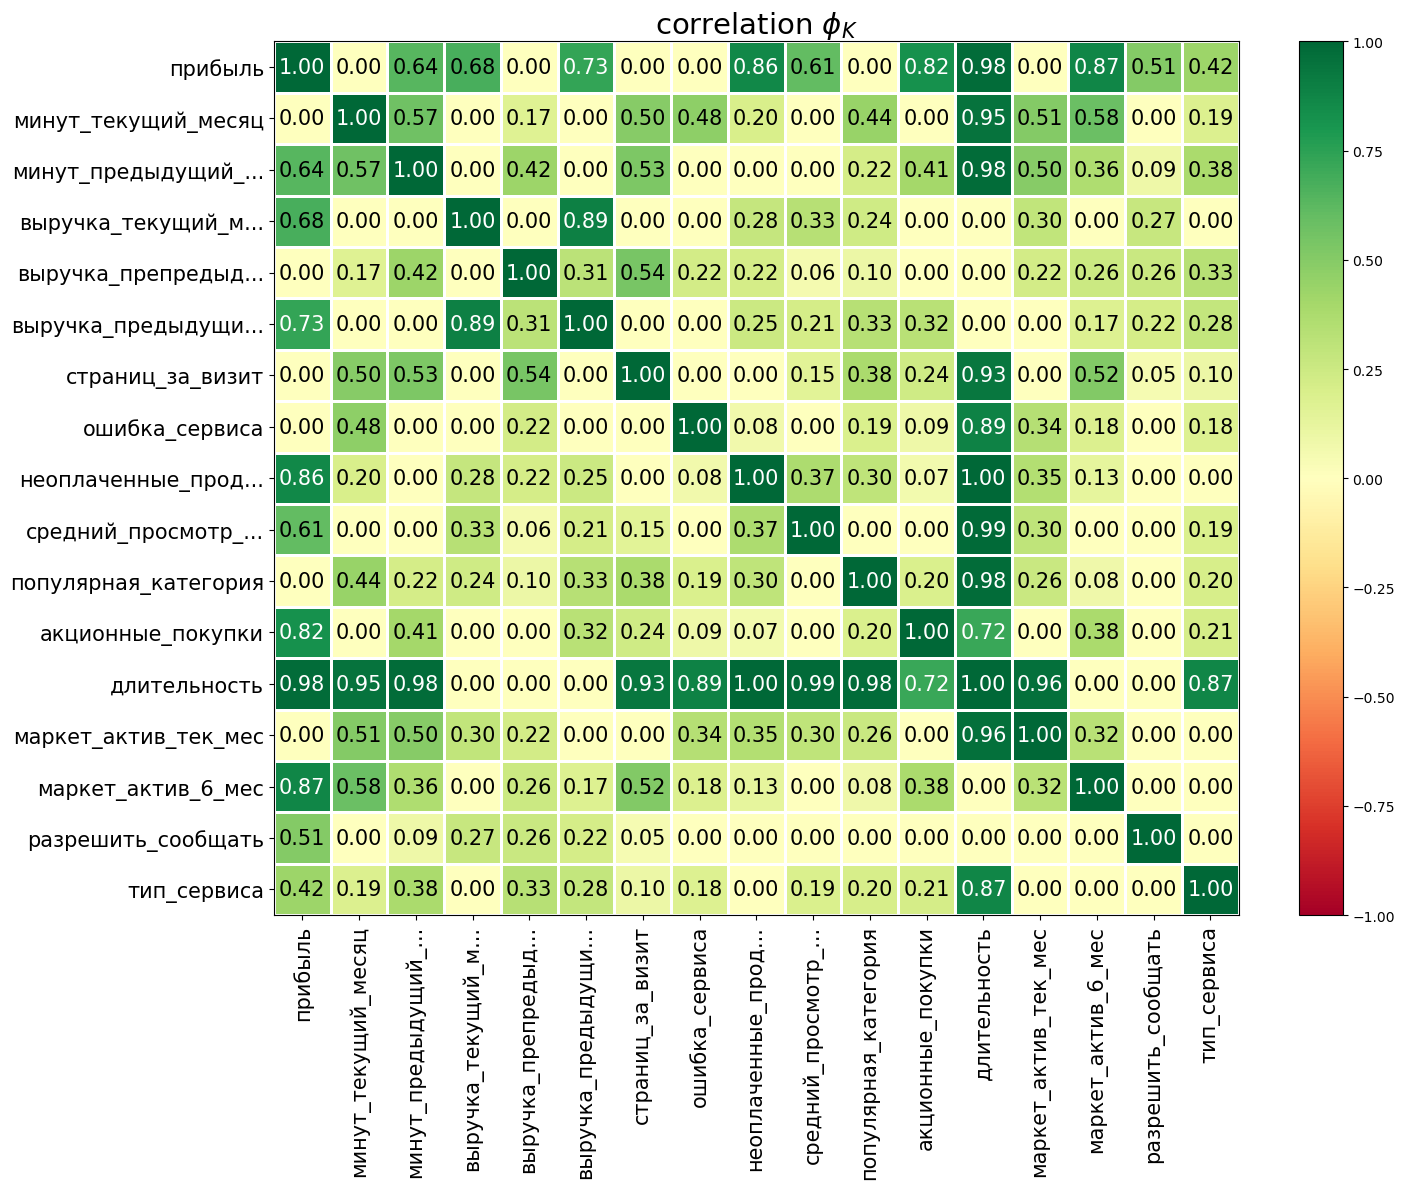

In [68]:
# визуализация тепловой карты коэффициентов корреляции для датафрейма df_low_activity
phik_overview = df_low_activity.drop(
    ['probabilities', 'покупательская_активность_x', 'покупательская_активность_y'],
    axis = 1).phik_matrix(interval_cols=interval_cols)


plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

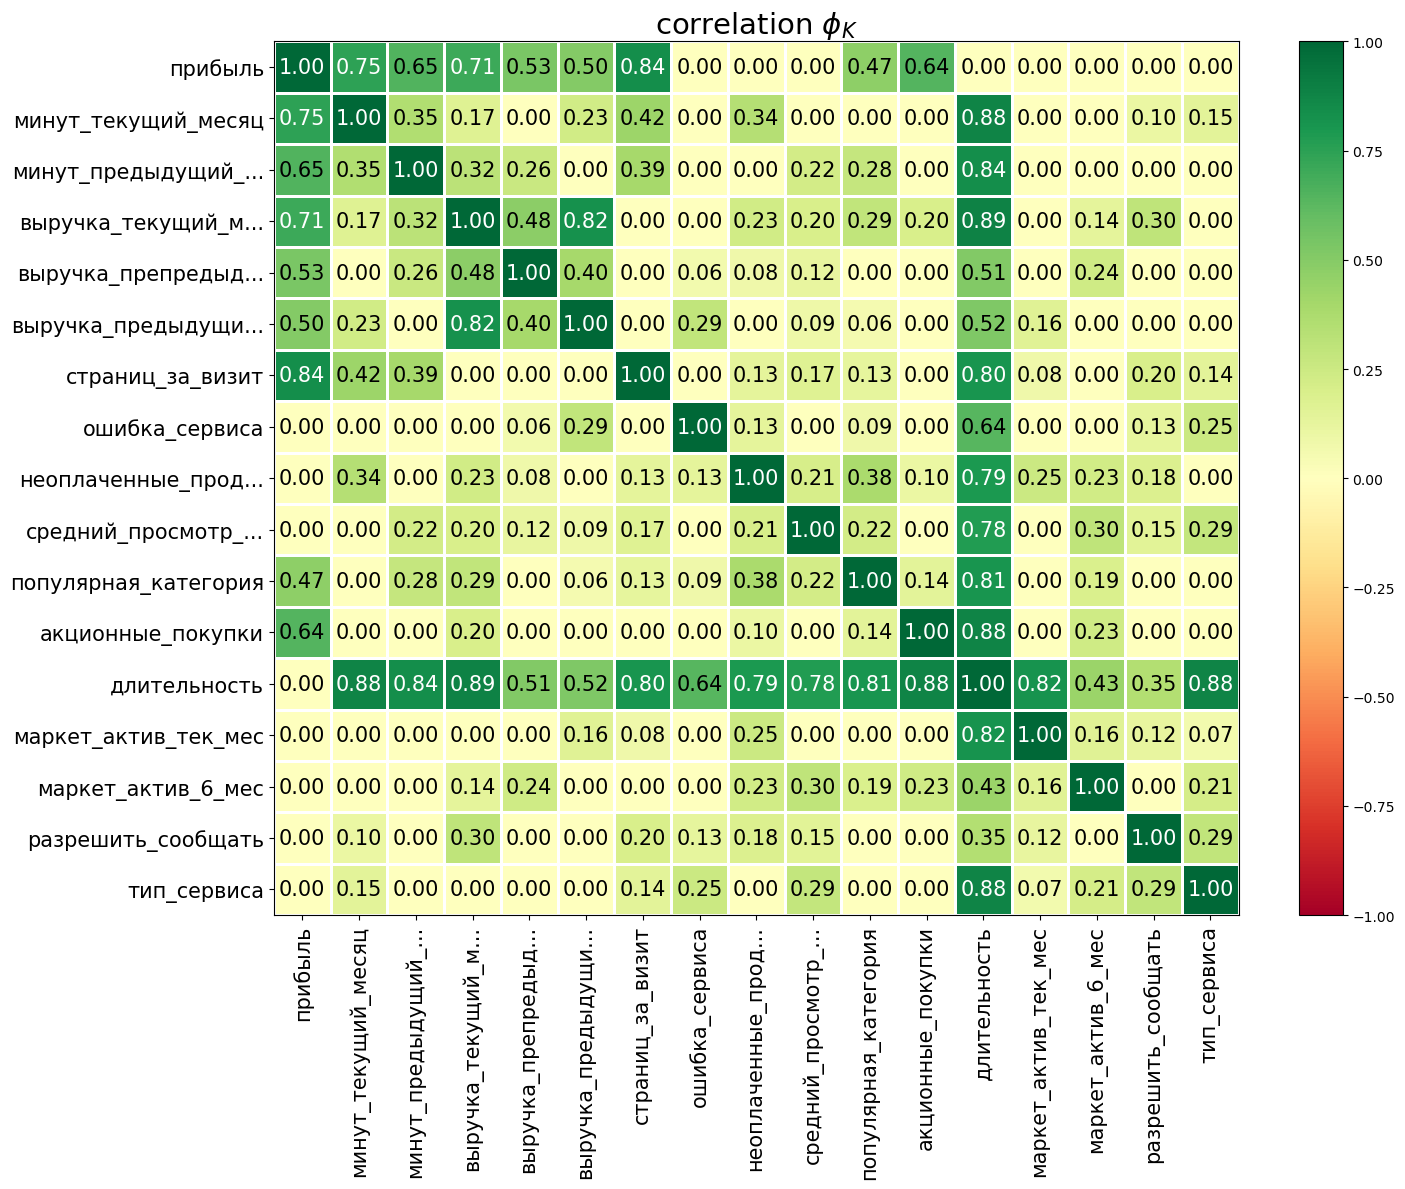

In [69]:
# визуализация тепловой карты коэффициентов корреляции для датафрейма df_unchanged_activity
phik_overview = df_unchanged_activity.drop(
    ['probabilities', 'покупательская_активность_x', 'покупательская_активность_y'],
    axis = 1).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

При сравнении двух полученных карт корреляции признаков видна разница:
1. в датафрейме df_low_activity наблюдается высокая корреляция между количеством просмотренных страниц, временем в предыдущем месяце и выручкой в предыдущем месяце. Высокая корреляция между прибылью и неоплаченными прдуктами, ошибкой сервиса, аукционными покупками, выручкой в предыдущем месяце и разрешить сообщать;
2. в датафрейме df_unchanged_activity с прибылью коррелируют другие признаки: минут в текущий месяц, минут в предыдущий месяц, выручка в текущий месяц, маркетинговая активность за 6 месяцев, популярная категория и страниц за визит. При этом ошибка сервиса не является значимым признаком.
3. Интересным фактом является то, что в обоих датафреймах длительность (время регистрации на сайте) коррелирует практически со всеми признаками, что не наблюдалось в исходном датафрейме.

Рассмотрим разницу в признаках более подробно

Определим несоторые функции для построения графиков

In [70]:
# Определим функцию для построения бар-диаграмм для одного столбца

"""""Функция для построения бар-диаграммы для сравнения столбца из двух разных двтвфреймов. 
Функция принимает названия датафреймов и двух столбцов, выдает бар-диаграмму"""


def compare_one_column(df1, df2, column):
    fig, ax = plt.subplots(figsize=(8, 5))

    bar_width = 0.5
    index = np.arange(2)

    rects1 = ax.bar(index, [df1[column].mean(), df2[column].mean()], bar_width, label=column)
    
    ax.set_xlabel('Датафреймы')
    ax.set_ylabel('Среднее значение')
    ax.set_title(f'Сравнение средних значений {column} двух датафреймов')
    ax.set_xticks(index)  # Set the positions for the x-tick labels
    ax.set_xticklabels(['Сниженная активность', 'Прежняя активность'])
    ax.legend()

    plt.show()

In [71]:
# Определим функцию для построения бар-диаграмм для двух столбцов

"""""Функция для построения бар-диаграммы для сравнения столбцов (двух) 
из двух разных двтвфреймов. Функция принимает названия датафреймов и двух столбцов,
выдает одну бар-диаграмму"""


def compare_two_columns(df1, df2, column1, column2):
    fig, ax = plt.subplots(figsize=(8, 5))

    bar_width = 0.35
    index = np.arange(2)

    rects1 = ax.bar(index, [df1[column1].mean(), df2[column1].mean()], bar_width, label=column1)
    rects2 = ax.bar(index + bar_width, [df1[column2].mean(), df2[column2].mean()], bar_width, label=column2)
         
    ax.set_xlabel('Датафреймы')
    ax.set_ylabel('Среднее значение')
    ax.set_title(f'Среднее значение {column1} и {column2} для двух датафремов')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(['Сниженная активность', 'Прежняя активность'])
    ax.legend()

    plt.tight_layout()
    plt.show()

In [72]:
# Определим функцию для построения бар-диаграмм для трех столбцов

"""""Функция для построения бар-диаграммы для сравнения столбцов (трех) 
из двух разных двтвфреймов. Функция принимает названия датафреймов и трех столбцов,
выдает одну бар-диаграмму"""


def compare_three_columns(df1, df2, column1, column2, column3):
    fig, ax = plt.subplots(figsize=(8, 5))

    bar_width = 0.2
    index = np.arange(2)
    
    rects1 = ax.bar(index-bar_width, [df1[column1].mean(), df2[column1].mean()], bar_width, label=column1)                     
    rects2 = ax.bar(index, [df1[column2].mean(), df2[column2].mean()], bar_width, label=column2)
    rects3 = ax.bar(index + bar_width, [df1[column3].mean(), df2[column3].mean()], bar_width, label=column3)
                        
    ax.set_xlabel('Датафреймы')
    ax.set_ylabel('Среднее значение')
    ax.set_title(f'Среднее значение {column1},\n {column2} и\n {column3} для двух датафремов')
    ax.set_xticks(index + bar_width / 3)
    ax.set_xticklabels(['Сниженная активность', 'Прежняя активность'])
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

    plt.tight_layout()
    plt.show()

In [73]:
# Определим функцию для построения бар-диаграмм для сравнения данных для категориального признака

"""""Функция для построения бар-диаграммы для сравнения данных из двух разных двтвфреймов 
в зависимости от принадлежности к той или иной категории.
Функция принимает названия датафреймов и столбец с данными для сравнения,
выдает одну бар-диаграмму"""

def compare_average_income_by_category(df1, df2, column):
    categories = ['Домашний текстиль', 'Косметика и аксесуары', 'Кухонная посуда',
                  'Мелкая бытовая техника и электроника', 'Техника для красоты и здоровья',
                  'Товары для детей']

    avg_income_df1 = []
    avg_income_df2 = []

    for cat in categories:
        avg_income_cat_df1 = df1[df1['популярная_категория'] == cat][column].mean()
        avg_income_df1.append(avg_income_cat_df1)

        avg_income_cat_df2 = df2[df2['популярная_категория'] == cat][column].mean()
        avg_income_df2.append(avg_income_cat_df2)

    fig, ax = plt.subplots(figsize=(10, 6))
    index = np.arange(len(categories))
    bar_width = 0.35

    rects1 = ax.barh(index, avg_income_df1, bar_width, label='Датафрейм 1')
    rects2 = ax.barh(index + bar_width, avg_income_df2, bar_width, label='Датафрейм 2')

    ax.set_ylabel('Популярные категории')
    ax.set_xlabel('Средняя прибыль')
    ax.set_title(f'Сравнение среднего значения {column} в популярных категориях для двух датафреймов')
    ax.set_yticks(index + bar_width / 2)
    ax.set_yticklabels(categories)
    ax.legend()

    plt.tight_layout()
    plt.show()

In [74]:
# Сравним сначала два датафрейма относительно наиболее частой категории продуктов в заказе

def compare_category_counts(df1, df2):
    categories = ['Домашний текстиль', 'Косметика и аксесуары', 'Кухонная посуда',
                  'Мелкая бытовая техника и электроника', 'Техника для красоты и здоровья',
                  'Товары для детей']

    counts_df1 = []
    counts_df2 = []

    for cat in categories:
        count_df1 = df1[df1['популярная_категория'] == cat].shape[0]
        counts_df1.append(count_df1)

        count_df2 = df2[df2['популярная_категория'] == cat].shape[0]
        counts_df2.append(count_df2)

    fig, ax = plt.subplots(figsize=(10, 5))
    index = np.arange(len(categories))
    bar_width = 0.35

    rects1 = ax.barh(index, counts_df1, bar_width, label='Сниженная активность')
    rects2 = ax.barh(index + bar_width, counts_df2, bar_width, label='Прежняя активность')

    ax.set_ylabel('Популярные категории')
    ax.set_xlabel('Количество клиентов')
    ax.set_title('Сравнение количества клиентов в популярных категориях для двух датафреймов')
    ax.set_yticks(index + bar_width / 2)
    ax.set_yticklabels(categories)
    ax.legend()

    plt.tight_layout()
    plt.show()

In [75]:

def compare_category_counts(df1, df2, column, categories):
    

    counts_df1 = []
    counts_df2 = []

    for cat in categories:
        count_df1 = df1[df1[column] == cat].shape[0]
        counts_df1.append(count_df1)

        count_df2 = df2[df2[column] == cat].shape[0]
        counts_df2.append(count_df2)

    fig, ax = plt.subplots(figsize=(10, 5))
    index = np.arange(len(categories))
    bar_width = 0.35

    rects1 = ax.barh(index, counts_df1, bar_width, label='Сниженная активность')
    rects2 = ax.barh(index + bar_width, counts_df2, bar_width, label='Прежняя активность')

    ax.set_ylabel('Популярные категории')
    ax.set_xlabel('Количество клиентов')
    ax.set_title('Сравнение количества клиентов в популярных категориях для двух датафреймов')
    ax.set_yticks(index + bar_width / 2)
    ax.set_yticklabels(categories)
    ax.legend()

    plt.tight_layout()
    plt.show()

##### Рассмотрим сначала продуктовое поведение

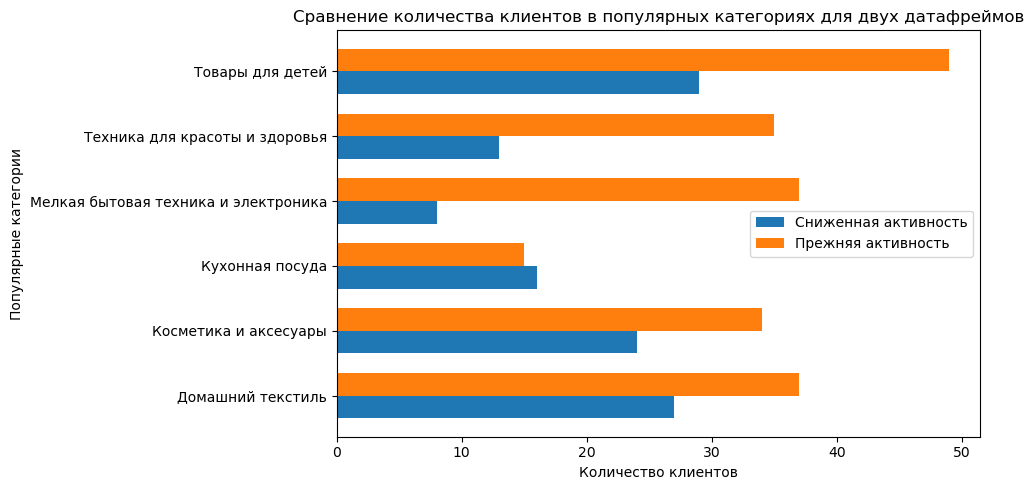

In [76]:
categories = ['Домашний текстиль', 'Косметика и аксесуары', 'Кухонная посуда',
                  'Мелкая бытовая техника и электроника', 'Техника для красоты и здоровья',
                  'Товары для детей']

compare_category_counts(df_low_activity, df_unchanged_activity, 'популярная_категория', categories)    

Из полученной бар-диаграммы видно, что распределение товаров по различным категориям у пакопателей со сниженной активностью практически повторяют распределени товаров у покупателей с прежней активностью.

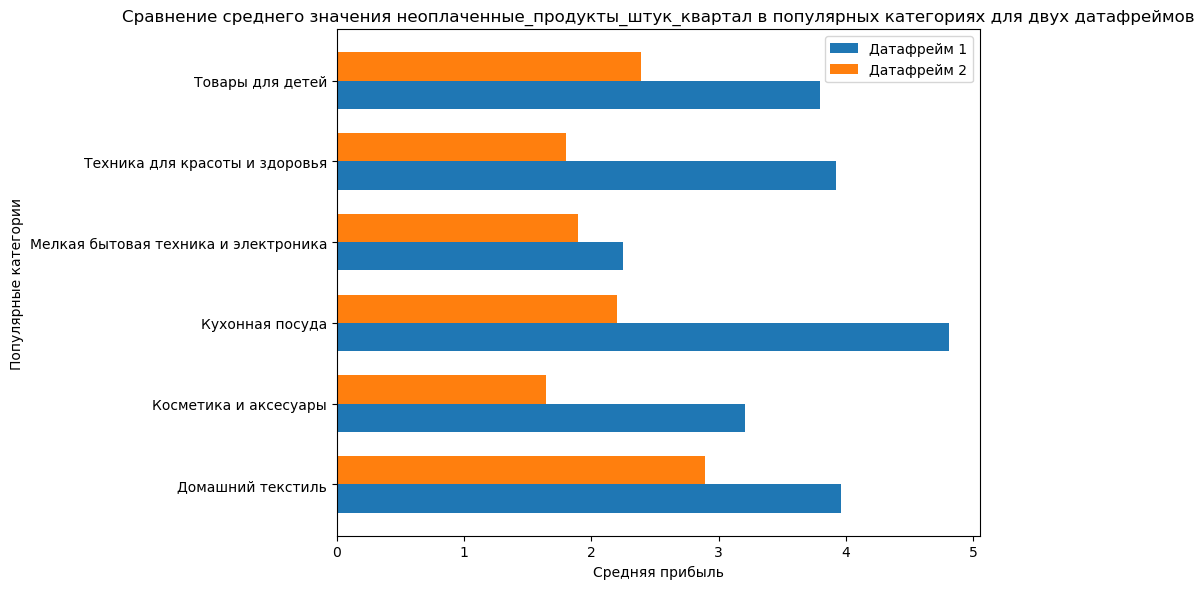

In [77]:
compare_average_income_by_category(df_low_activity, df_unchanged_activity, 
                                   'неоплаченные_продукты_штук_квартал')

Видно, что по всем категорям у покупателей со сниженной активностью количество неоплаченных товаров сильно выш.

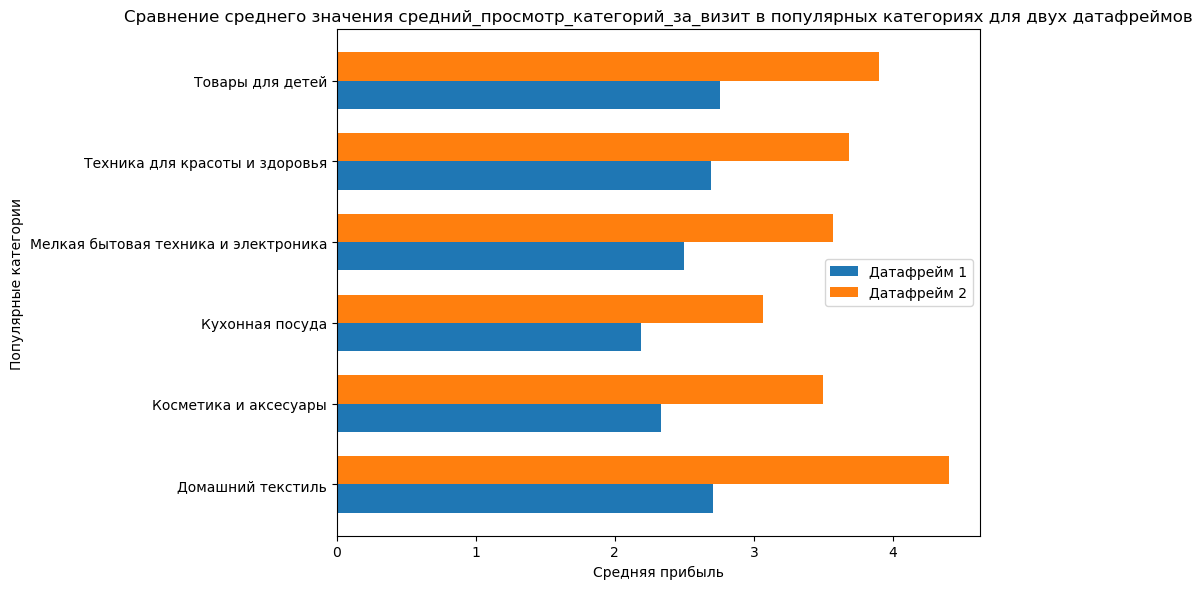

In [78]:
compare_average_income_by_category(df_low_activity, df_unchanged_activity, 
                                   'средний_просмотр_категорий_за_визит')

По показателю средний просмотр за визит оба дата фрейма практически не различаются.

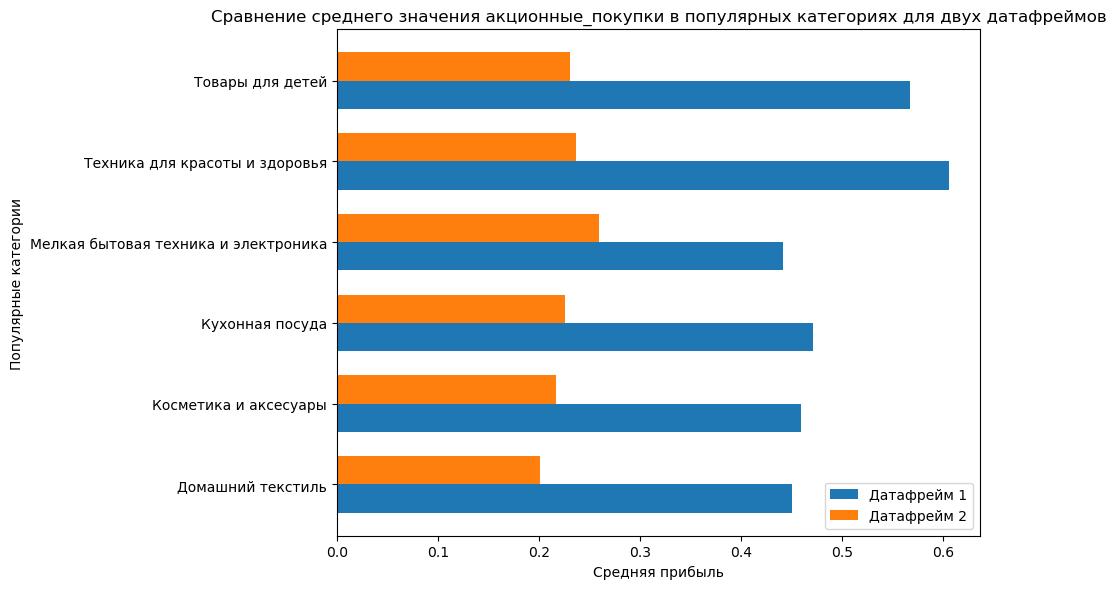

In [79]:
compare_average_income_by_category(df_low_activity, df_unchanged_activity, 
                                   'акционные_покупки')

Что касается аукцинных покупок, то в этом случае поккпатели со сниженной активностью проявляют более высокий интерес к аукцинным товарам.

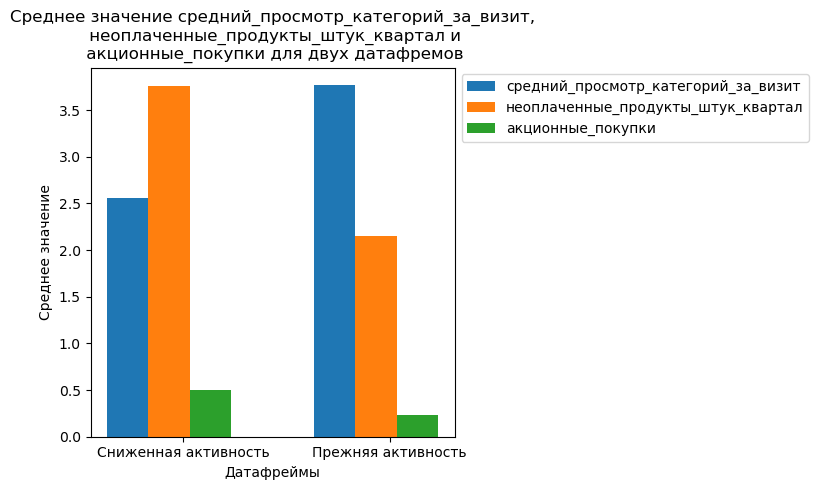

In [80]:
compare_three_columns(df_low_activity, df_unchanged_activity, 
                    'средний_просмотр_категорий_за_визит',
                    'неоплаченные_продукты_штук_квартал', 
                    'акционные_покупки')

Без распределения по категорям товаров также видно, что клиенты со сниженной активностью просматривают меньшее количество категорий товаров, имеют больше неоплаченных покупок и более заинтересованы в аукционных товарах.

In [81]:
df_low_activity.groupby('популярная_категория')['неоплаченные_продукты_штук_квартал'].mean()

популярная_категория
Домашний текстиль                       3.962963
Косметика и аксесуары                   3.208333
Кухонная посуда                         4.812500
Мелкая бытовая техника и электроника    2.250000
Техника для красоты и здоровья          3.923077
Товары для детей                        3.793103
Name: неоплаченные_продукты_штук_квартал, dtype: float64

In [82]:
df_unchanged_activity.groupby('популярная_категория')['неоплаченные_продукты_штук_квартал'].mean()

популярная_категория
Домашний текстиль                       2.891892
Косметика и аксесуары                   1.647059
Кухонная посуда                         2.200000
Мелкая бытовая техника и электроника    1.891892
Техника для красоты и здоровья          1.800000
Товары для детей                        2.387755
Name: неоплаченные_продукты_штук_квартал, dtype: float64

У покупателей со сниженной активностью из неоплаченных товаров, на втором месте находятся товары, относящиеся к красоте и здоровью и только после этого домашний текстиль и товары для детей.  

##### Рассмотрим финансовое поведение клиентов

In [83]:
# Определим разницу в выречке между месяцами для каждого датафрейма


In [84]:
df_low_activity = df_low_activity.copy()
df_low_activity.loc[:, 'разница_препред_предмесяц'] = df_low_activity[
    'выручка_предыдущий_месяц'] - df_low_activity['выручка_препредыдущий_месяц']
df_low_activity.loc[:, 'разница_пред_текущ_месяц'] = df_low_activity[
    'выручка_текущий_месяц'] - df_low_activity['выручка_предыдущий_месяц']

df_unchanged_activity = df_unchanged_activity.copy()
df_unchanged_activity.loc[:, 'разница_препред_предмесяц'] = df_unchanged_activity[
    'выручка_предыдущий_месяц'] - df_unchanged_activity['выручка_препредыдущий_месяц']
df_unchanged_activity.loc[:, 'разница_пред_текущ_месяц'] = df_unchanged_activity[
    'выручка_текущий_месяц'] - df_unchanged_activity['выручка_предыдущий_месяц']

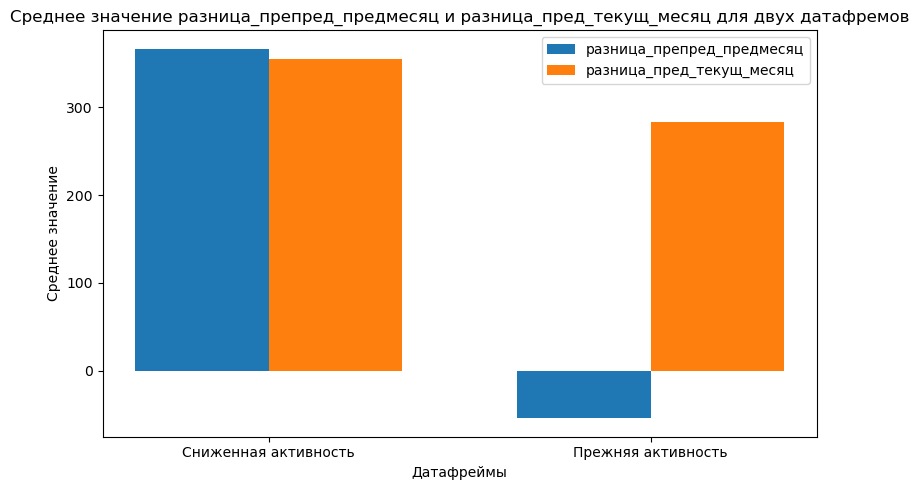

In [85]:
compare_two_columns(
    df_low_activity, df_unchanged_activity, 
    'разница_препред_предмесяц', 'разница_пред_текущ_месяц')

Из бар диаграммы видно, что финансовое поведение у покупателей со сниженной активностью сильно отличается от финансовго поведения покупателей с прежней активностью. Если разница в выручке за текущий и предыдущий месяц у них примерно одинаковая, то за месяц до этого разница в выручке от покупателей со сниженной активностью сильно упала.

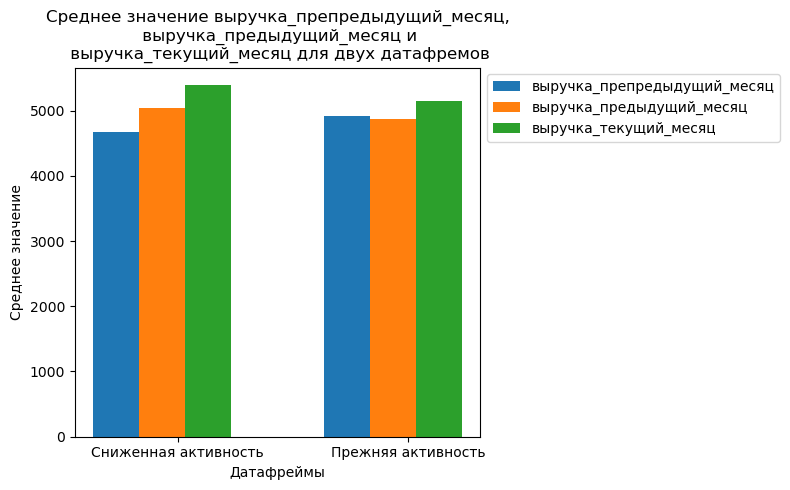

In [86]:
compare_three_columns(df_low_activity, df_unchanged_activity, 
                    'выручка_препредыдущий_месяц',
                    'выручка_предыдущий_месяц', 
                    'выручка_текущий_месяц')

Если посмотреть на среднюю выручку за каждый месяц, то отличия между финансовым поведением покупателей со сниженной и прежней активностью не наблюдаются.

##### Рассмотрим поведение клиентов на сайте

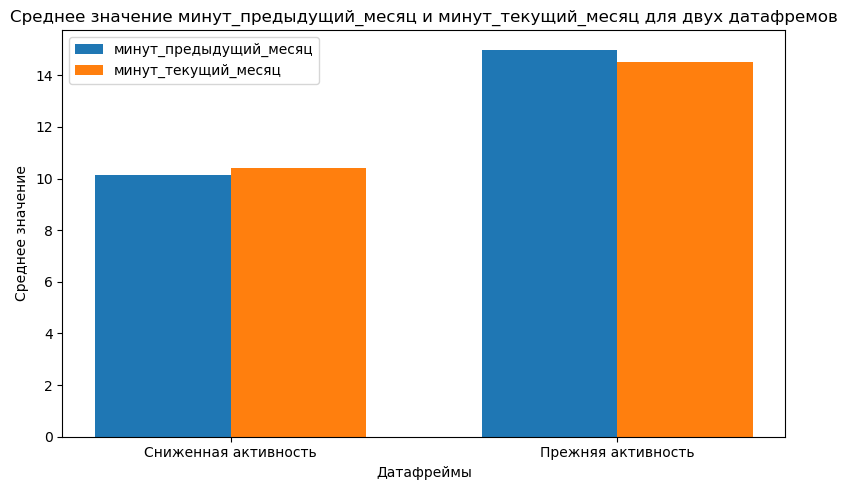

In [87]:
compare_two_columns(df_low_activity, df_unchanged_activity, 
                    'минут_предыдущий_месяц', 'минут_текущий_месяц')

Из диаграммы видно, что клиенты со сниженной активностью в среднем проводят меньше времени на сайте.

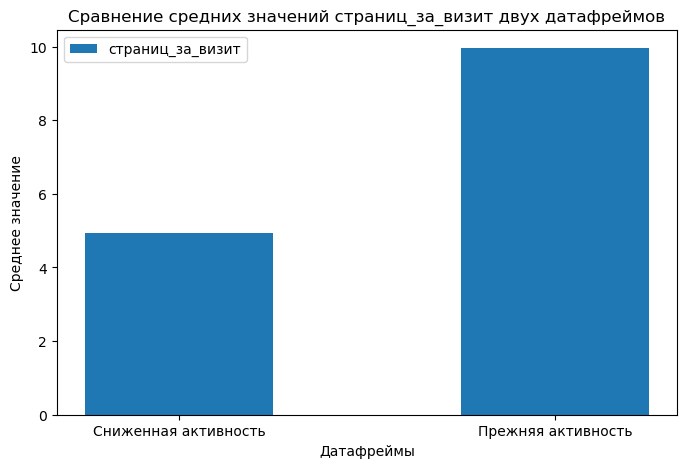

In [88]:
compare_one_column(df_low_activity, df_unchanged_activity, 'страниц_за_визит')

Они также просматривают меньшее количество страниц за визит

##### Рассмотрим коммуникацию с клиентами 

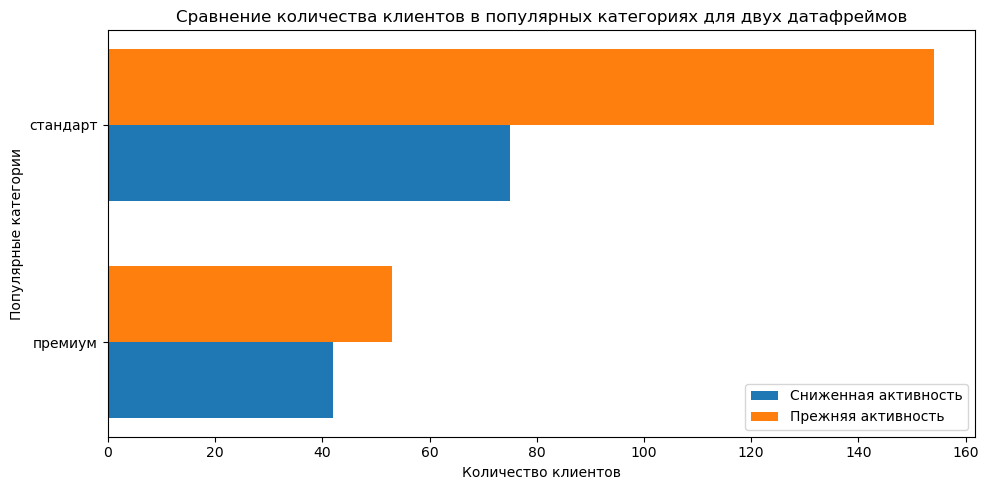

In [89]:
category = ['премиум', 'стандарт']
compare_category_counts(df_low_activity, df_unchanged_activity, 'тип_сервиса', category)

Среди покупателей со сниженной категорией разница между покупателями категорий Премиум и Стандарт гораздо ниже, чем среди покупателей с прежней активностью, где преобладают покупатели категории Стандарт

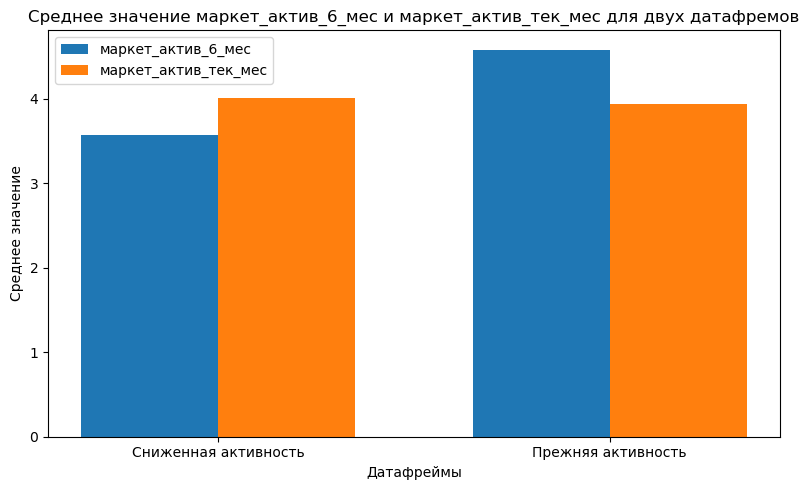

In [90]:
compare_two_columns(
    df_low_activity, df_unchanged_activity, 
    'маркет_актив_6_мес', 'маркет_актив_тек_мес')

Маркетинговая активность в течение 6 месяцев в отношении покупателей со сниженной активностью ниже, чем в отношении покупателей с прежней активностью.

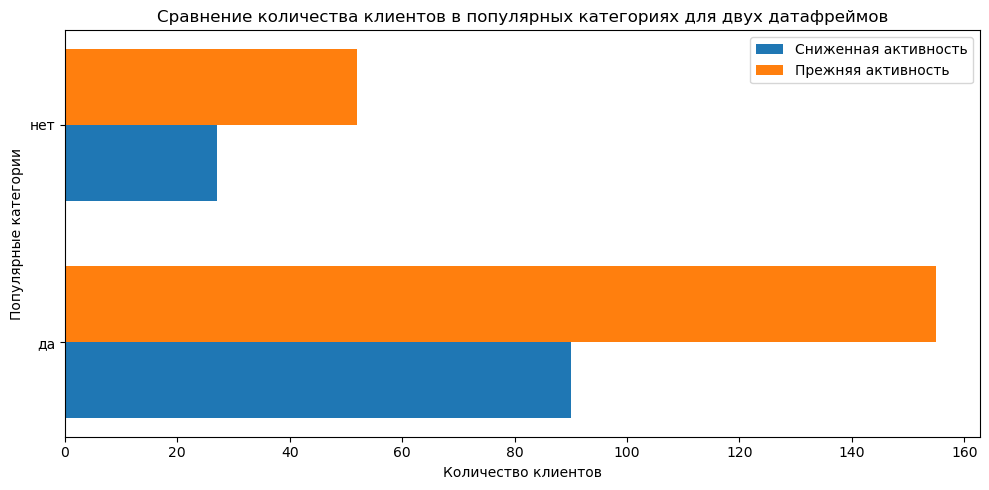

In [91]:

category = ['да', 'нет']
compare_category_counts(df_low_activity, df_unchanged_activity, 'разрешить_сообщать', category)

Что касается разрешения сообщений, то здесь особых отличий нет

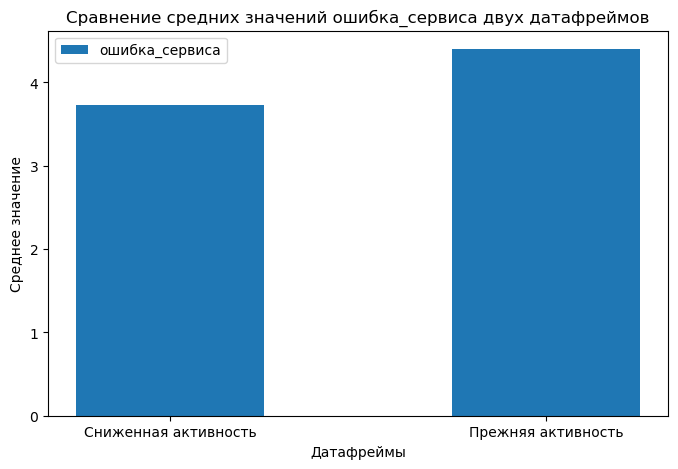

In [92]:
compare_one_column(df_low_activity, df_unchanged_activity, 'ошибка_сервиса')

Среднее количество ошибок сервиса у покупателей со сниженной активностью даже ниже, чем у покупателей с прежней активностью.

Можно сделать следующий вывод:
1. Предсказать покупательскую активность клиента можно по признакам поведения клиента на сайте и по его финансовой активности.
2. Не оказывают влияние признаки, относящиеся к маркетингу или самому сайту, поскольку признак, относящийся к ошибкам сайта вообще не вошел в ранг важных признаков.

### Общие выводы
1. Выполнен корреляционный анализ признаков, который показал, что явная корреляция между покупательской активностью наблюдается только для признаков 'Выручка_текущий_месяц' и 'Выручка_предыдущий_месяц' (0,87), а также 'страниц за визит' и 'покупательская активность' (0,57). Со многими признаками коррелирует признак 'длительность', хотя этот признак практически не отличается между клиентами со сниженной и прежней активностью.
2. Наилучшей моделью для предсказания покупательской активности является SVC(class_weight='balanced', probability=True). Однако поскольку эта модель трудна для интерпретации важности признаков, была найдена вторая лучшая модель для предсказаний - Логистическая регрессия. Для оценки качества предсказаний выбрана метрика ROC-AUC, которая позволяет оценить качество работы модели в случае, когда объектов с одним значением целевого признака больше, чем с другим.
3. Важными признаками для предсказания активности клиента являются: средний просмотр категорий за визит, количество страниц за визит, минут в предыдущий месяц, количество неоплаченных продуктов, аукционные покупки, минут в текущем месяце и активный маркетинг за 6 месяцев. Важной категорией является мелкая бытовая техника и электроника.
4. Признаки, относящиеся к маркетингу или самому сайту не оказывают существенного влияния, о чем свидетельствует признак, лотносящийся к ошибкам сайта, который даже не вошел в ранг важных признаков при рассмотрении исходного датафрейма. Однако при сравнении выборок покупателей со сниженной и прежней активностью выяснилось, что в выборке покупателей со сниженной активностью признак ошибка сервиса сильно коррелирует с прибылью.

### Рекомендации:
Согласно результатам анализа выяснилось, что клиенты со сниженной и прежней потребительской активность сильнее всего различаются по продуктовому поведению, что вероятно связано с финансовыми возможностями покупателей, поскольку покупатели со сниженной активностью проявляют более высокий интерес к аукцинным покупкам по сравнению с покупателями с прежней активностью. Какие возможны рекомендации:
1. Проверить не связано ли снижение потребительской активности клиента с изменениями, сделанными на сайте в текущем месяце (если таковые имели место).
2. Внести разнообразие в аукцинные покупки.
3. Возможно стоит продумать систему кредитования, поскольку количество неоплаченных товаров сильно больше у покупателей со сниженной активностью. 
3. Не снижать маркетинговую активность, поскольку она приводит к увеличению активности клиента на сайте.
4. Проанализировать продукты, которые остаются неоплаченными.
5. Проанализировать финансовую политику в отношении клиентов, поскольку деление на Премиум и Стандарт не оказывают существенного влияния на потребительскую активность.
6. Следует также проанализировать, на каком этапе чаще возникали ошибки сервиса у покупателей со сниженной активностью, поскольку, как выяснилось при дальнейшем анализе, ошибка сервиса у этой категории клиентов оказывает влияние на их финансовую активность.  